# Машинное обучение, DS-поток
## Задание ML.7K


**Правила:**

* Дедлайны см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*
* В каждой задаче не забывайте делать **пояснения и выводы**.


**Правила оформления теоретических задач:**

* Решения необходимо прислать одним из следующих способов:
  * фотографией в правильной ориентации, где все четко видно, а почерк разборчив,
    * отправив ее как файл боту вместе с ноутбуком *или*
    * вставив ее в ноутбук посредством `Edit -> Insert Image` (<font color="red">фото, вставленные ссылкой, не принимаются</font>);
  * в виде $\LaTeX$ в markdown-ячейках.
* Решения не проверяются, если какое-то требование не выполнено. Особенно внимательно все проверьте в случае выбора второго пункта (вставки фото в ноутбук). <font color="red"><b>Неправильно вставленные фотографии могут не передаться при отправке.</b></font> Для проверки попробуйте переместить `ipynb` в другую папку и открыть его там.
* В решениях поясняйте, чем вы пользуетесь, хотя бы кратко. Например, если пользуетесь независимостью, то достаточно подписи вида "*X и Y незав.*"
* Решение, в котором есть только ответ, и отсутствуют вычисления, оценивается в 0 баллов.

**Баллы за задание:**

* Задача 2 &mdash; 90 баллов + бонусные баллы + медальки + гуси.


In [72]:
# Bot check

# HW_ID: ds_ml7k
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: not final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [1]:
import copy
import numpy as np
import pandas as pd

import xgboost as xgb
from xgboost import XGBRegressor, XGBClassifier, DMatrix

from catboost import CatBoostRegressor, Pool, CatBoostClassifier
from catboost.datasets import titanic

import lightgbm
from sklearn.model_selection import train_test_split

from sklearn.model_selection import StratifiedShuffleSplit, GroupShuffleSplit, ShuffleSplit
from sklearn.model_selection import StratifiedGroupKFold, StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.tree import DecisionTreeRegressor

from xgboost import plot_tree as plot_xgb_tree
from lightgbm import plot_tree as plot_lgbm_tree
from sklearn.tree import plot_tree as plot_sklearn_tree

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.3, palette='Set2')

---

### Задача 2

Рассмотрим одну из уже классических задач машинного обучения — предсказание кредитного рейтинга клиентов кредитной организации. В данной задаче вам нужно провести анализ данных, построить классификатор клиентов и отправить свои предсказания в Kaggle-соревнование.

Кредитный скоринг — система оценки кредитоспособности (кредитных рисков) потенциальных и действующих клиентов, в основу которой вкладываются статистические данные. Кредитный скоринг широко используется как крупными банками, микрофинансовыми организациями, так и в потребительском (магазинном) экспресс-кредитовании на небольшие суммы. Также возможно его использование в бизнесе сотовых операторов, страховых компаний и т. д. Скоринг заключается в присвоении баллов по заполнению некой анкеты, разработанной оценщиками кредитных рисков андеррайтерами. По результатам набранных баллов системой автоматически принимается решение об одобрении или отказе в выдаче кредита.

Описание данных:
* `client_id`: уникальный идентификатор клиента;
* `month`: месяц сбора информации;
* `age`: возраст клиента;
* `occupation`: вид деятельность;
* `annual_income`: годовой доход;
* `monthly_salary`: зарплата за текущий месяц;
* `number_bank_accounts`: количество банковских счетов у данного клиента;
* `number_credit_cards`: количество кредитных карт у данного клиента;
* `interest_rate`: процентная ставка по кредитной карте;
* `number_loan`: количество кредитов, взятых в банке;
* `delay_from_due_date`: среднее количество дней задержки выплат по кредиту;
* `number_delayed_payment`: количество платежей по кредиту, которые были выполнены с задержкой;
* `number_credit_inquiries`: количество запросов по кредиту;
* `unpaid_debt`: сумма долга;
* `credit_utilization_ratio`: коэффициент использования кредитных карт;
* `credit_history_age`: размер кредитной истории;
* `min_amount_payment`: была ли произведенная выплата минимально возможной;
* `monthy_amount_invested`: сумма инвестиций за месяц;
* `client_behaviour`: платежное поведение клиента;
* `monthly_balance`: баланс по итогу месяца;
* `credit_rating`: кредитный рейтинг — это **целевой признак**.

Ссылка: https://www.kaggle.com/competitions/ds-2024-autumn-37/

Инвайт: https://www.kaggle.com/t/785866ded4ce4fa09236c47cc2724d65

**Правила**

* В Kaggle в данное тренировочное соревнование можно отправлять не более 7 решений в день (8-ю система не позволит).
* Решения индивидуальные.
* Качество считается по метрике Accuracy.
* До окончания соревнования доступны значения качества, посчитанные только на случайных 30% тестовых данных. Значения отображаются в Public Leaderboard.
* После окончания соревнования становится доступным Private Leaderboard, в котором значения качества посчитанны на оставшихся 70% объектов.
* Для включения в Private Leaderboard можно выбрать две посылки.
* В Leaderboard должны отображаться ваши **реальные имя и фамилия**. В противном случае решение может быть не зачтено.
* Все файлы, которые вы отправляете в соревнование, видны организаторам соревнования. Файлы должны иметь понятное имя, при отправке файла в систему необходимо написать краткое описание решения. **Это будет проверяться.**
* В решении, отправляемом боту, должно быть отображено, результаты каких моделей вы отправляете в соревнование.
* Не забывайте сделать пояснения к своему решению. **Решение может быть не зачтено, если в нем недостаточно пояснений**, даже если удалось попасть в топ-3.
* Пользоваться можно любыми пройденными в наших курсах моделями.
* Нельзя пользоваться любыми методами и моделями, которые мы не проходили, и которых не было в ранее в иных курсах, которые обязательны для всех.
* Код студентов, занявших первые 3 места, будет запускаться. Также выборочно может запускаться код и остальных студентов.

**Советы**

* Чтобы получить действительно хороший результат подбора гиперпараметров мало, попробуйте ввести новые признаки для улучшения качества решения.
* Некоторые инсайты по тому, какие признаки могут улучшить качество, можно получить если провести разведывательный анализ данных (EDA). Например, может иметь смысл изучить датасет на предмет наличия выбросов, исследовать пространственное и временное распределение отклика. 
* Изучите различные методы, предложенные на занятиях.
* Сохраняйте код и результаты каждой модели в отдельных файлах. Добавляйте к ним понятные описания, которые помогут вам при необходимости продолжить использовать решение.

**Сроки сдачи**
 
* **Дедлайн в Kaggle** совпадает с дедлайном по заданию (25.10 16:00). Дедлайн строгий, Kaggle не позволит сдать даже на секунду позже.
* Также **до дедлайна необходимо сдать в бот** существующий вариант решения, возможно, без пояснений.
* **До конца следующих суток  (26.10 23:59)** необходимо дооформить решение, соответствующее наилучшему варианту по Private Leaderboard и сдать в бот по отдельной кнопке. **Решение может быть не зачтено, если в нем недостаточно пояснений**, даже если удалось попасть в топ-3.
* В случае, если вы до основного дедлайна сдаете оформленное решение, его нужно сдать по двум кнопкам сразу &mdash; соответствующей основной сдаче, и отдельной для оформленного решения.

**Баллы**

* **Выдаются только при соблюдении всех правил** и суммируются.
* 15 баллов — ваше решение лучше `sample_submission.csv` на Public Leaderboard.
* 15 баллов — ваше решение дает качество не менее 65% на Public Leaderboard.
* по 15 баллов — за каждый следующий преодоленный порог на Private Leaderboard, пороги: 66%, 66.3%, 66.6%, 67%.
* 30 баллов за попадание в топ-3 на Private Leaderboard и **шоколадная медаль** за соответствующее место.
* **Шоколадная медаль** попадание в топ-10 на Private Leaderboard.
* **Мягкий гусь**
    * за топ-1 на Private Leaderboard
    * за наиболее хорошо оформленное решение
    * за самую оригинальную идею (которая привела к улучшению).

Для начала загрузим данные:

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
train

,client_id,month,age,occupation,annual_income,monthly_salary,number_bank_accounts,number_credit_cards,interest_rate,number_loan,...,number_delayed_payment,number_credit_inquiries,unpaid_debt,credit_utilization_ratio,credit_history_age,min_amount_payment,monthy_amount_invested,client_behaviour,monthly_balance,credit_rating
0,5e261a2ce0,Февраль,NaN,NaN,34811.50,2977.666667,2,4,6.0,1.0,...,4.0,2.0,605.03,24.464031,26 г. 7 м.,No,104.291825,"Малые траты, малые платежи",463.220627,Обычный
1,5e261a2ce0,Март,28.0,Учитель,34231.28,2991.866667,2,4,6.0,1.0,...,1.0,2.0,605.03,38.550848,26 г. 8 м.,No,40.391238,"Большие траты, большие платежи",478.941214,Хороший
2,5e261a2ce0,Апрель,28.0,Учитель,NaN,2979.906667,2,1385,6.0,1.0,...,NaN,2.0,605.03,33.224951,26 г. 9 м.,No,58.515976,"Большие траты, большие платежи",464.256476,Обычный
3,5e261a2ce0,Май,28.0,Учитель,34376.73,NaN,2,4,6.0,1.0,...,NaN,2.0,605.03,39.182656,26 г. 10 м.,No,99.306228,"Малые траты, средние платежи",457.656224,Хороший
4,5e261a2ce0,Июнь,28.0,Учитель,34415.88,2958.436667,2,4,6.0,1.0,...,1.0,2.0,605.03,34.977895,26 г. 11 м.,No,130.115420,"Малые траты, малые платежи",443.497032,Хороший
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,273554f220,Май,45.0,Медиаменеджер,15962.71,1510.639167,1,1,5.0,4.0,...,NaN,8.0,897.16,36.132095,21 г. 4 м.,No,199.988581,"Малые траты, малые платежи",197.400775,Хороший
63996,273554f220,Июнь,NaN,Медиаменеджер,16518.23,1504.069167,1,1,5.0,4.0,...,0.0,8.0,897.16,37.788217,21 г. 5 м.,No,64.549748,"Малые траты, большие платежи",310.219608,Плохой
63997,273554f220,Июль,45.0,Медиаменеджер,16081.07,1495.929167,1,1,5.0,4.0,...,NaN,8.0,897.16,24.972853,21 г. 6 м.,No,NaN,"Малые траты, малые платежи",224.671539,Хороший
63998,273554f220,Август,45.0,Медиаменеджер,NaN,1455.459167,1,1,5.0,4.0,...,NaN,8.0,897.16,36.166925,21 г. 7 м.,No,NaN,"Малые траты, малые платежи",339.924834,Хороший


Сразу видим и кучу пропусков в данных, и дупликаты по `client_id`, и гору категориальных признаков. Отсюда следует что лучше всего будет использовать модель `CatBoost`, поскольку он умеет работать с категориальными признаками лучше остальных. Также видим выбросы (какие 1385 кредитных карт, лоол). Для начала, дропнем `client_id` (но не дупликаты по ним, поскольку при разных обстоятельствах меняется и кредитный рейтинг). Также переведем `credit_history_age` в месяцы

In [4]:
train = train.drop(columns='client_id')
test = test.drop(columns='client_id')

def convert_to_months(age_str):
    if pd.isna(age_str):
        return 0
    years, months = 0, 0
    parts = age_str.split()
    for i in range(len(parts)):
        if 'г.' in parts[i]:
            years = int(parts[i-1])
        elif 'м.' in parts[i]:
            months = int(parts[i-1])
    return years * 12 + months

train['credit_history_age'] = train['credit_history_age'].apply(convert_to_months)
test['credit_history_age'] = test['credit_history_age'].apply(convert_to_months)
train

,month,age,occupation,annual_income,monthly_salary,number_bank_accounts,number_credit_cards,interest_rate,number_loan,delay_from_due_date,number_delayed_payment,number_credit_inquiries,unpaid_debt,credit_utilization_ratio,credit_history_age,min_amount_payment,monthy_amount_invested,client_behaviour,monthly_balance,credit_rating
0,Февраль,NaN,NaN,34811.50,2977.666667,2,4,6.0,1.0,3,4.0,2.0,605.03,24.464031,319,No,104.291825,"Малые траты, малые платежи",463.220627,Обычный
1,Март,28.0,Учитель,34231.28,2991.866667,2,4,6.0,1.0,7,1.0,2.0,605.03,38.550848,320,No,40.391238,"Большие траты, большие платежи",478.941214,Хороший
2,Апрель,28.0,Учитель,NaN,2979.906667,2,1385,6.0,1.0,3,NaN,2.0,605.03,33.224951,321,No,58.515976,"Большие траты, большие платежи",464.256476,Обычный
3,Май,28.0,Учитель,34376.73,NaN,2,4,6.0,1.0,3,NaN,2.0,605.03,39.182656,322,No,99.306228,"Малые траты, средние платежи",457.656224,Хороший
4,Июнь,28.0,Учитель,34415.88,2958.436667,2,4,6.0,1.0,3,1.0,2.0,605.03,34.977895,323,No,130.115420,"Малые траты, малые платежи",443.497032,Хороший
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,Май,45.0,Медиаменеджер,15962.71,1510.639167,1,1,5.0,4.0,1,NaN,8.0,897.16,36.132095,256,No,199.988581,"Малые траты, малые платежи",197.400775,Хороший
63996,Июнь,NaN,Медиаменеджер,16518.23,1504.069167,1,1,5.0,4.0,1,0.0,8.0,897.16,37.788217,257,No,64.549748,"Малые траты, большие платежи",310.219608,Плохой
63997,Июль,45.0,Медиаменеджер,16081.07,1495.929167,1,1,5.0,4.0,1,NaN,8.0,897.16,24.972853,258,No,NaN,"Малые траты, малые платежи",224.671539,Хороший
63998,Август,45.0,Медиаменеджер,NaN,1455.459167,1,1,5.0,4.0,1,NaN,8.0,897.16,36.166925,259,No,NaN,"Малые траты, малые платежи",339.924834,Хороший


Зададим, какие признаки категориальные, а какие вещественные:

In [126]:
target = 'credit_rating'
cat_features = ['occupation', 'month', 'min_amount_payment', 'client_behaviour']
real_features = ['age', 'annual_income', 'monthly_salary', 'number_bank_accounts', 'credit_history_age','number_credit_cards', 'interest_rate', 'number_loan', 'delay_from_due_date', 'number_delayed_payment', 'number_credit_inquiries', 'unpaid_debt', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_balance']

Посмотрим, есть ли явные выбросы в данных по вещественным признакам:

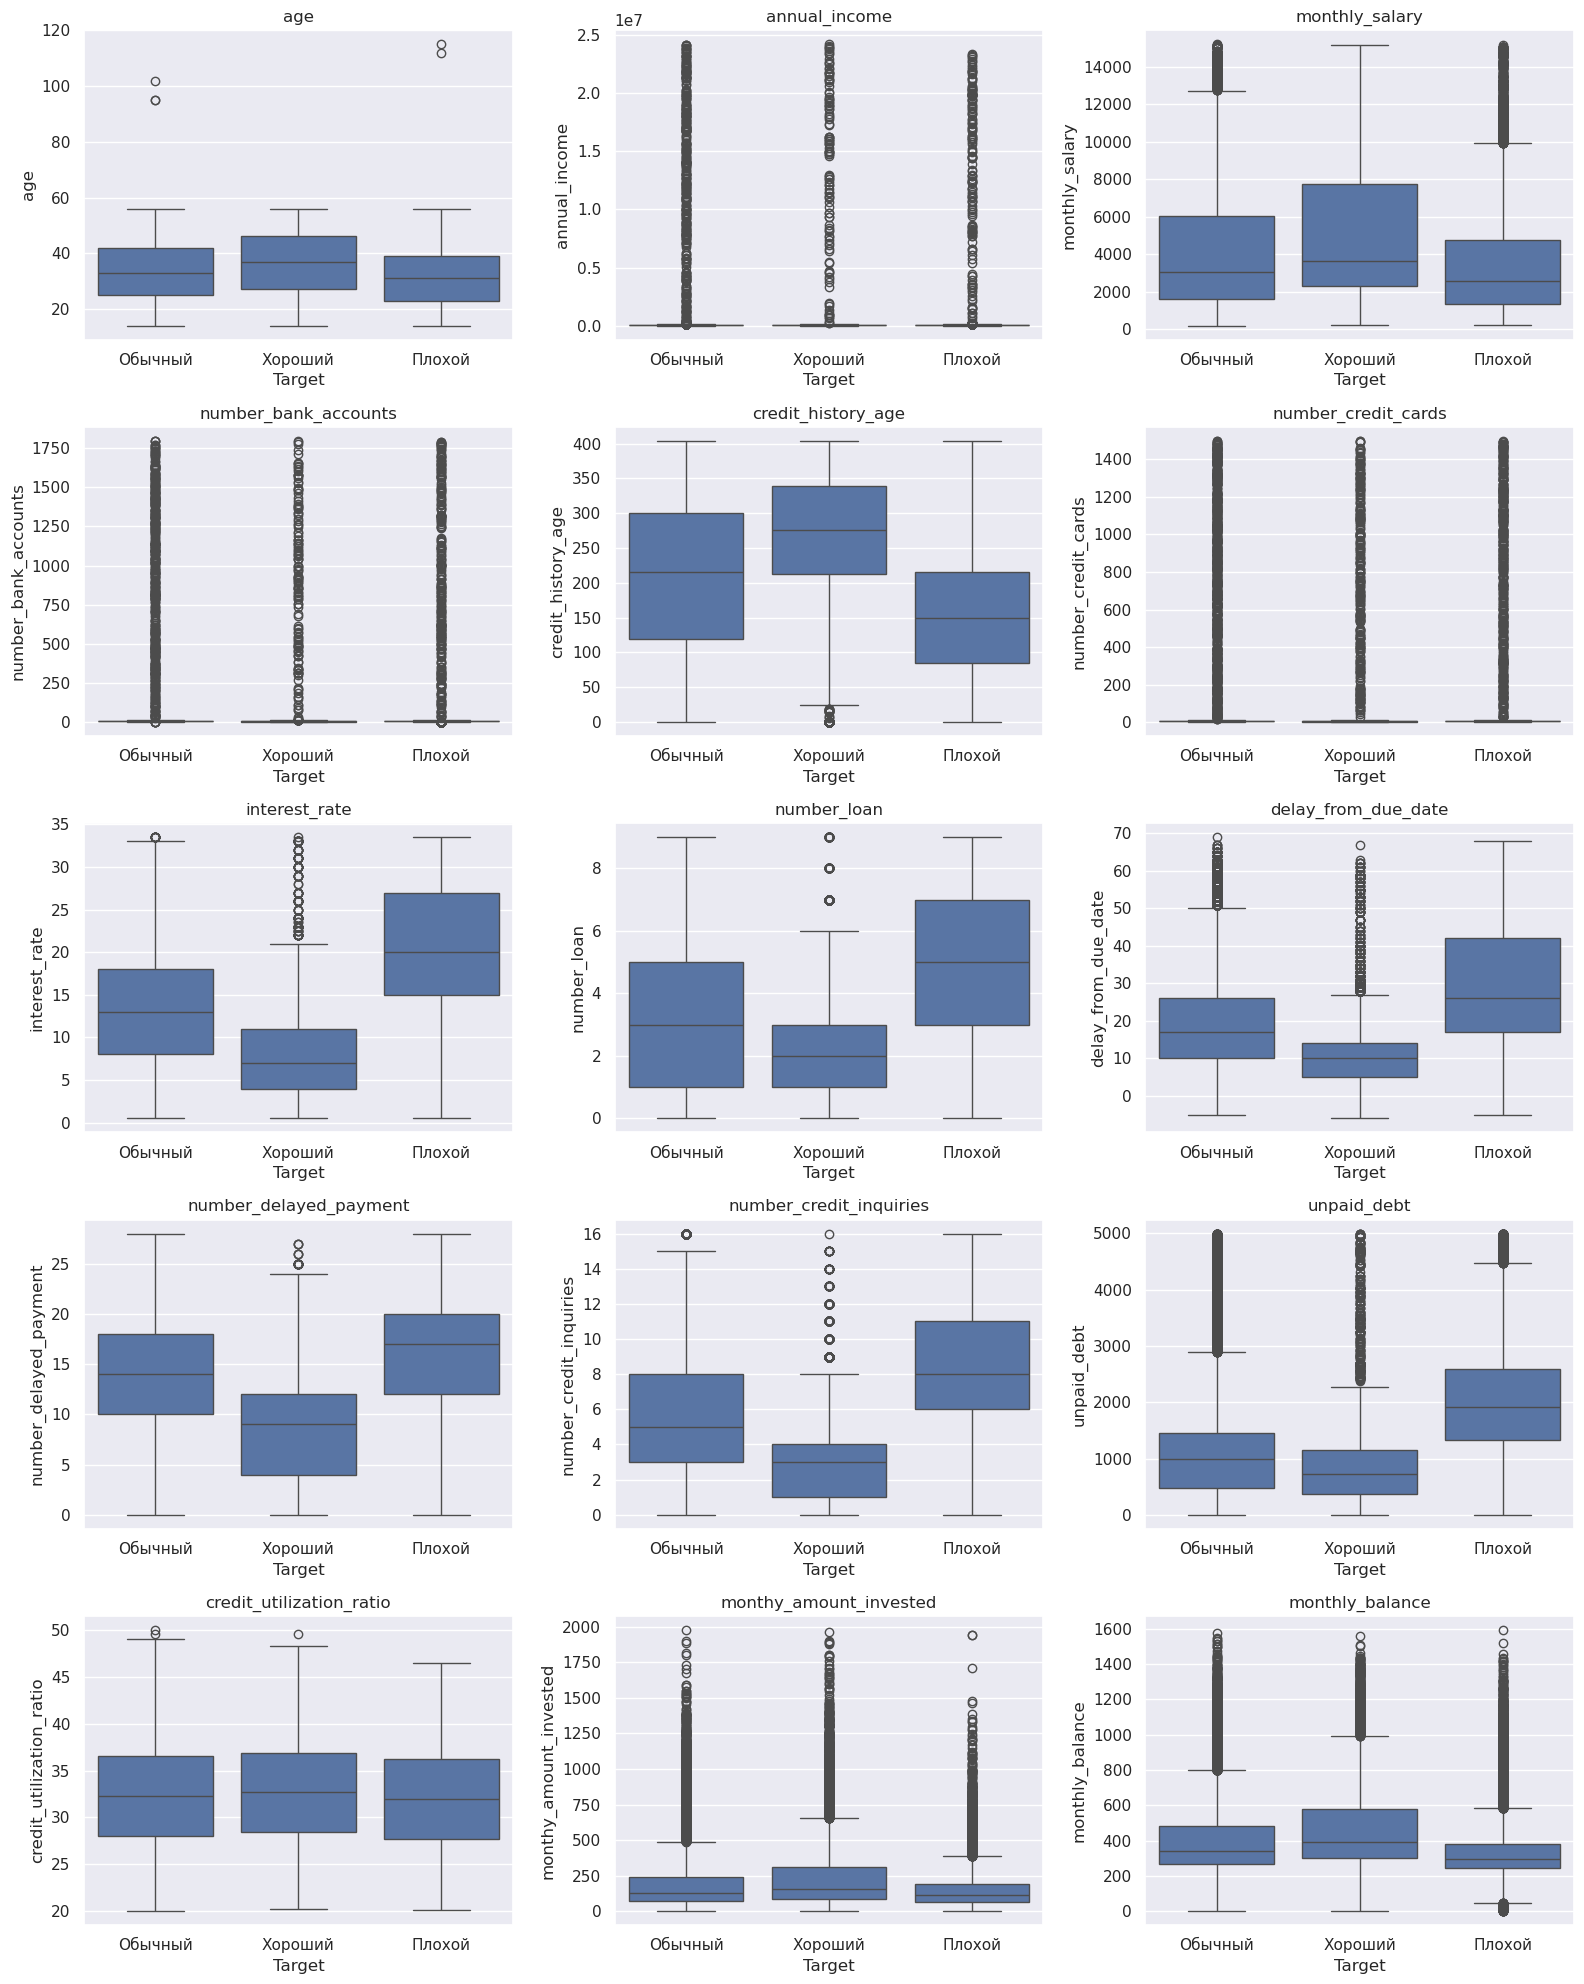

In [127]:
# Установка стиля графиков
sns.set(style="darkgrid")
plt.figure(figsize=(16, 20))
for i, param in zip(range(1, 16), real_features):
    ax = plt.subplot(5, 3, i)
    sns.boxplot(x='credit_rating', y=param, data=train, ax=ax)
    ax.set_title(f'{param}')
    ax.set_xlabel('Target')
    ax.set_ylabel(param)
    plt.tight_layout()

plt.show()

Попробуем прологарифмировать признаки и повторить исследование:

/tmp/ipykernel_32868/1503710816.py:3: RuntimeWarning: divide by zero encountered in log
  return np.log(num + 1)
/tmp/ipykernel_32868/1503710816.py:3: RuntimeWarning: invalid value encountered in log
  return np.log(num + 1)


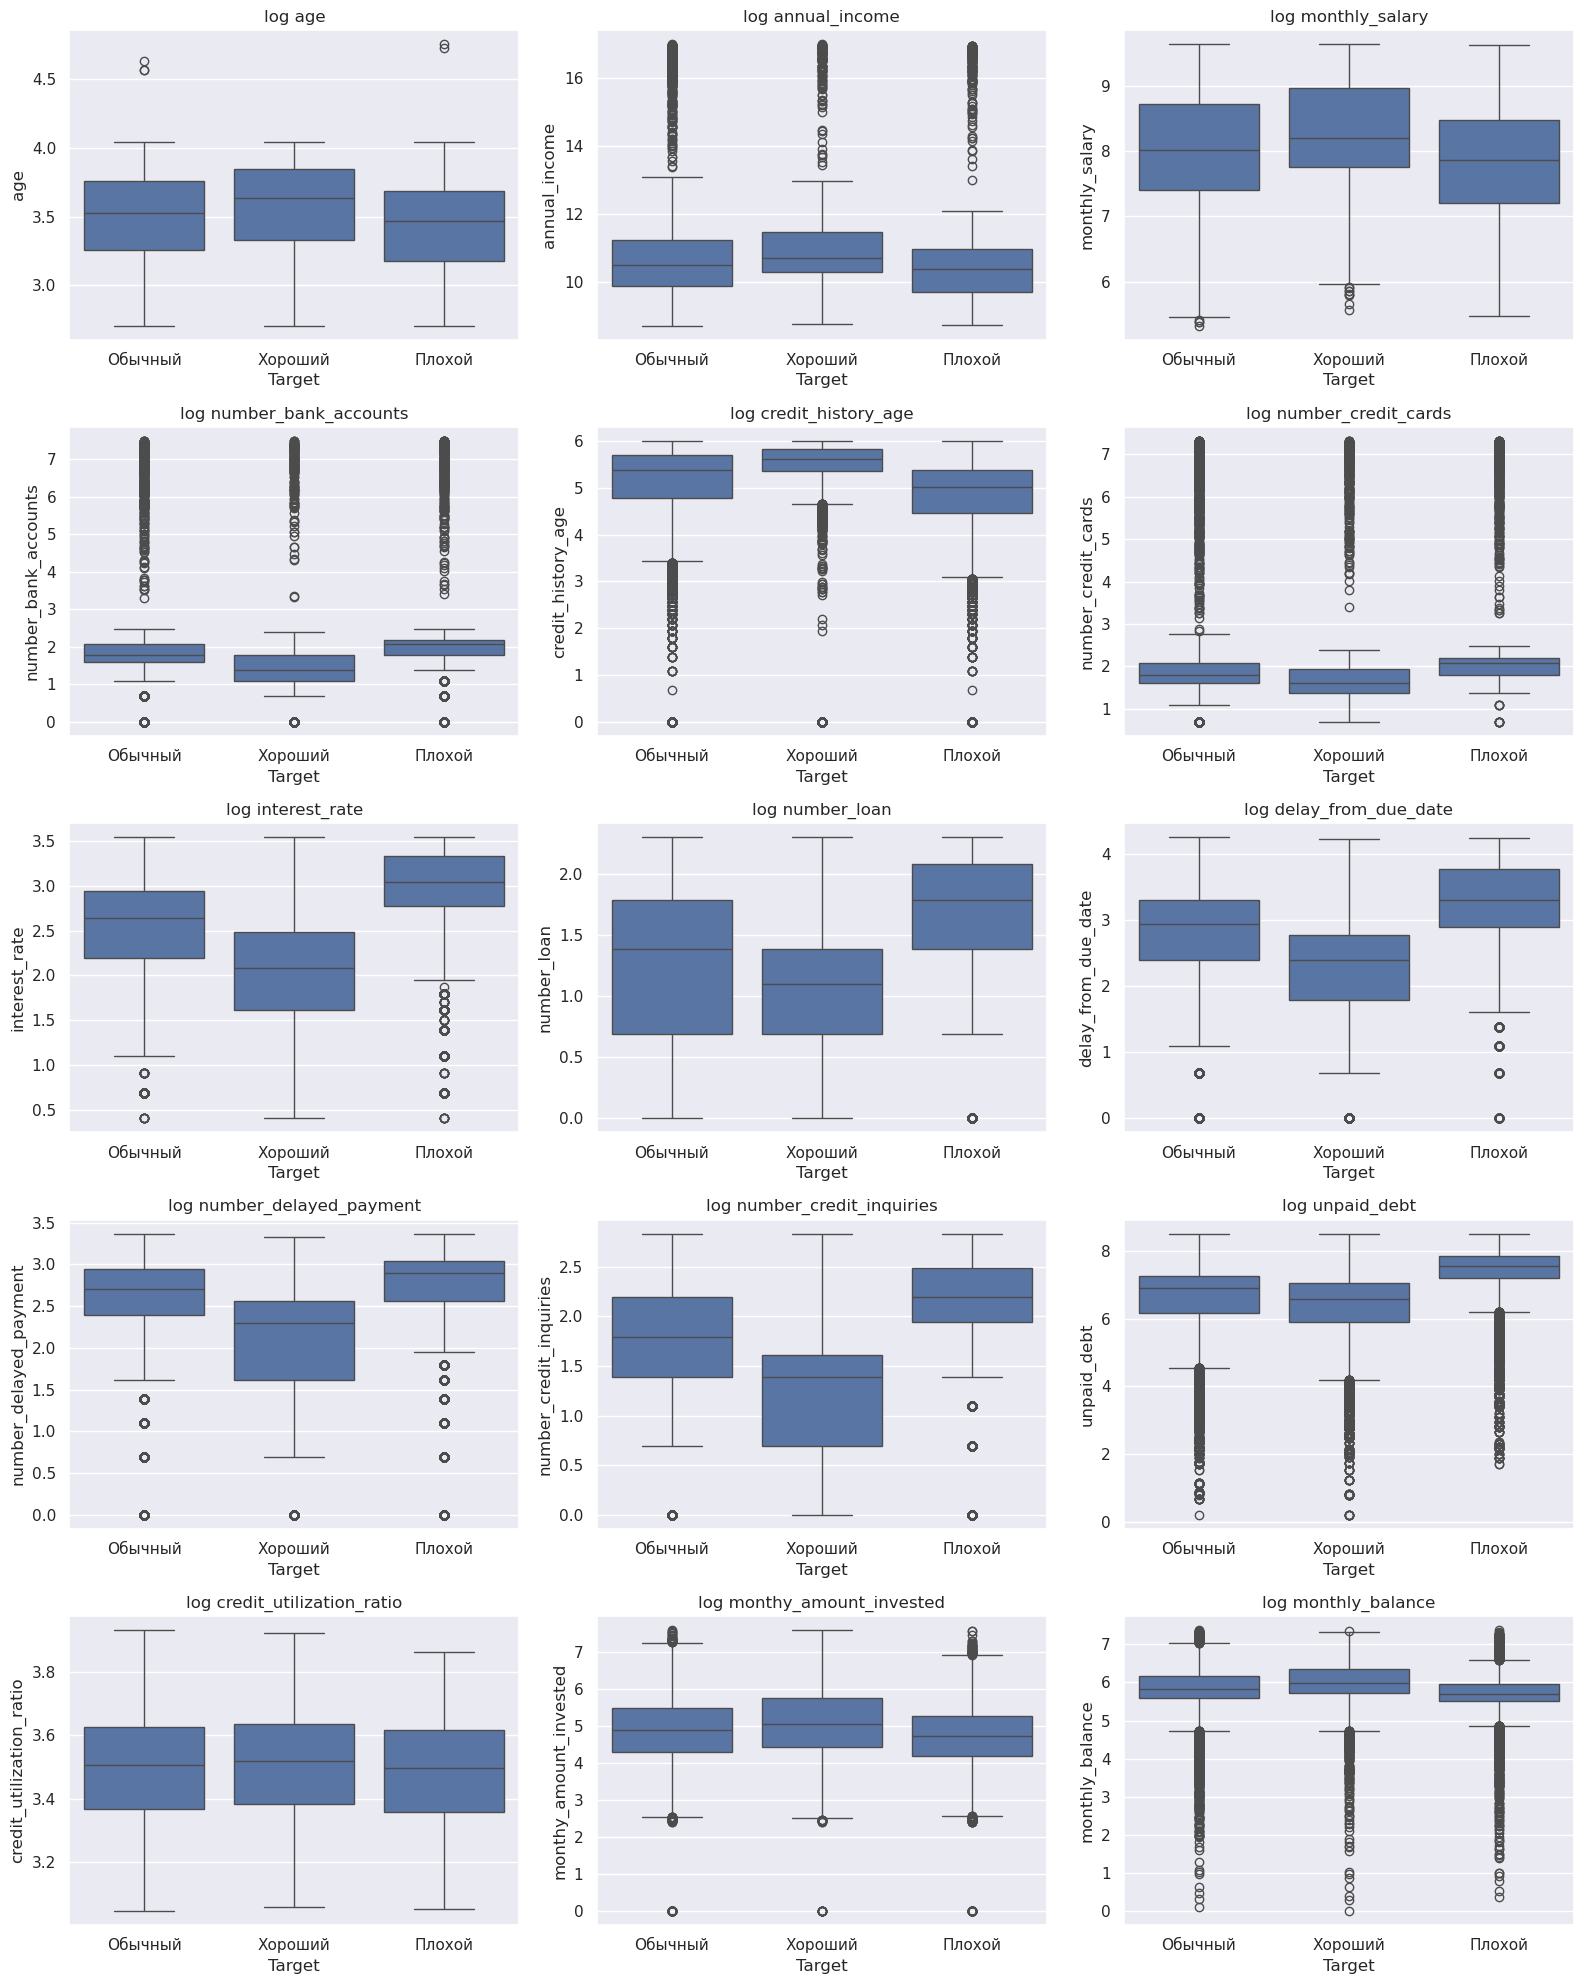

In [128]:
def log_num(num):
    if not pd.isna(num):
        return np.log(num + 1)

train_copy = train.copy()
for feature in real_features:
    train_copy[feature] = train_copy[feature].apply(log_num)
plt.figure(figsize=(16, 20))
for i, param in zip(range(1, 16), real_features):
    ax = plt.subplot(5, 3, i)
    sns.boxplot(x='credit_rating', y=param, data=train_copy, ax=ax)
    ax.set_title(f'log {param}')
    ax.set_xlabel('Target')
    ax.set_ylabel(param)
    plt.tight_layout()

plt.show()

Сделаем отдельные выводы по каждому признаку:
* `age`:                      свечи разные, выбросов нет, `Хороший` признак
* `annual_income`:            свечи микроскопические, тонна выбросов, `Плохой` признак
* `monthly_salary`:           свечи разные, немного выбросов, `Средний` признак
* `number_bank_accounts`:     свечи микроскопические, тонна выбросов, `Плохой` признак,
* `number_credit_cards`:      свечи микроскопические, тонна выбросов, `Плохой` признак
* `interest_rate`:            свечи очень разные, выбросов минимально, `Хороший` признак
* `number_loan`:              свечи очень разные, выбросов минимально, `Хороший` признак
* `delay_from_due_date`:      очень разные свечи, многовато выбросов, `Средний` признак
* `number_delayed_payment`:   свечи очень разные, выбросов минимально, `Хороший` признак
* `number_credit_inquiries`:  свечи очень разные, выбросов минимально, `Хороший` признак
* `unpaid_debt`:              очень разные свечи, но многовато выбросов, `Средний` признак
* `credit_utilization_ratio`: свечи очень разные, выбросов минимально, `Хороший` признак
* `credit_history_age`:       свечи очень разные, выбросов минимально, `Хороший` признак
* `monthy_amount_invested`:   очень разные свечи, но многовато выбросов, `Средний` признак
* `monthly_balance`:          очень разные свечи, но многовато выбросов, `Средний` признак

Посмотрим также на количество пропущенных значений по каждому признаку:

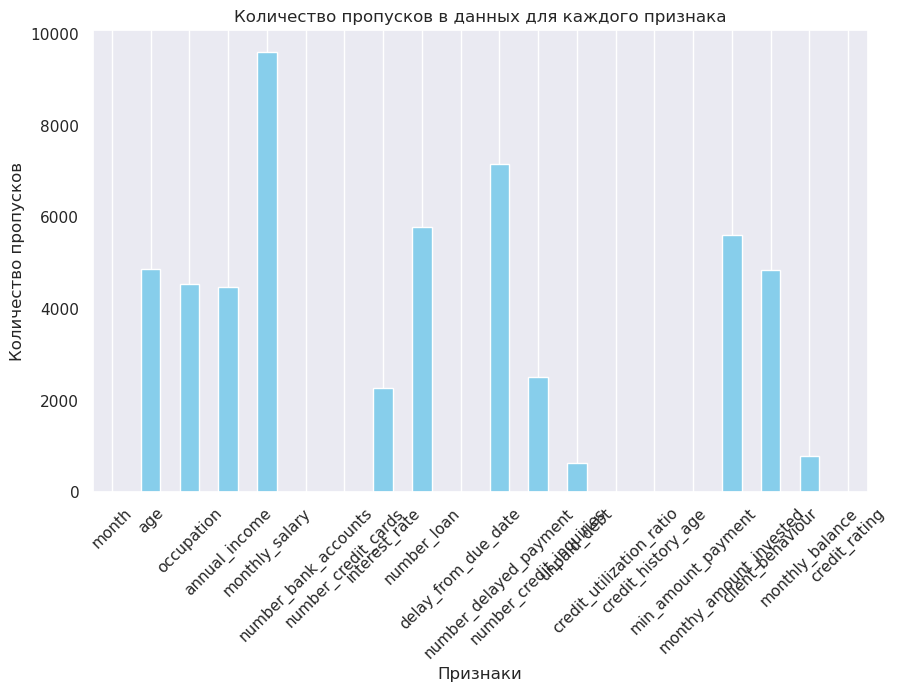

In [111]:
missing_counts = train.isnull().sum()

# Строим гистограмму
plt.figure(figsize=(10, 6))
missing_counts.plot(kind='bar', color='skyblue')
plt.title('Количество пропусков в данных для каждого признака')
plt.xlabel('Признаки')
plt.ylabel('Количество пропусков')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

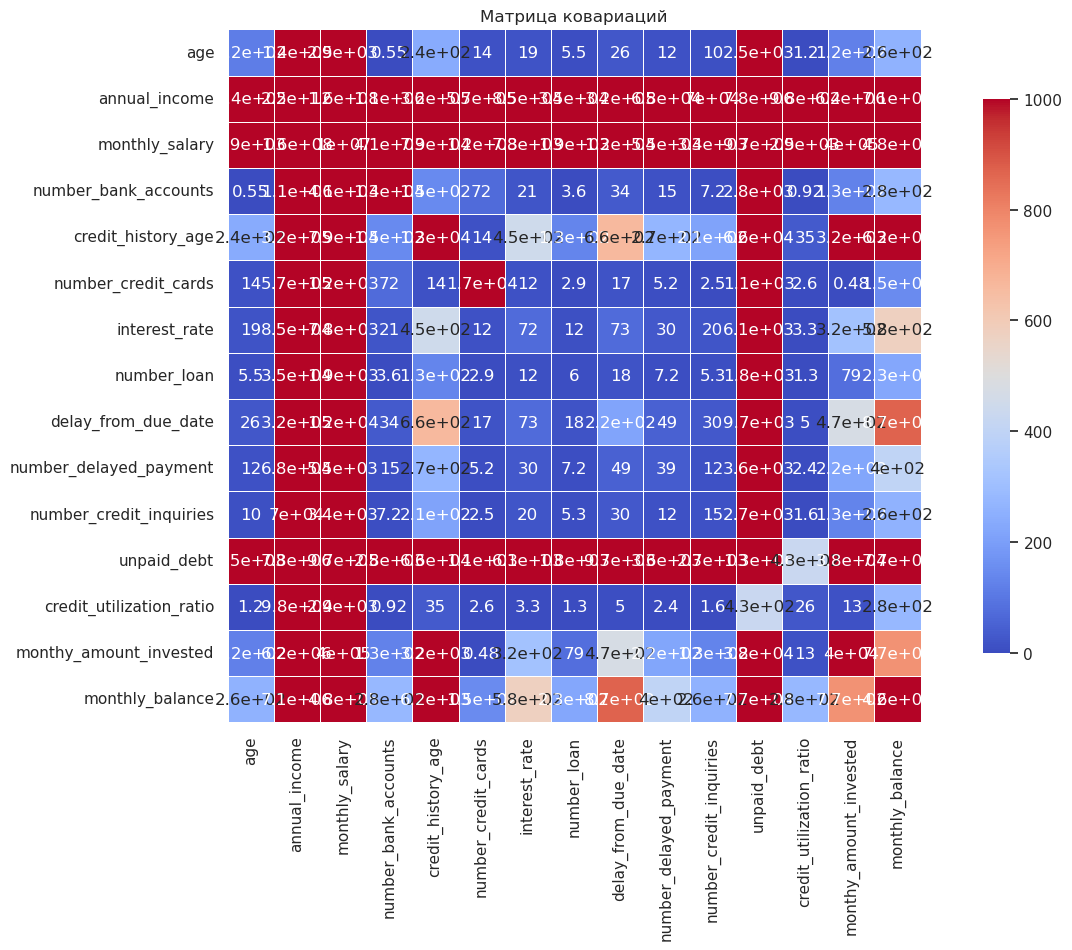

In [116]:
cov_matrix = train[real_features].cov()

# Построение тепловой карты
plt.figure(figsize=(16, 9))
sns.heatmap(np.abs(cov_matrix), annot=True, cmap='coolwarm', square=True, cbar_kws={"shrink": .8}, linewidth=.5, vmin=0, vmax=1000)
plt.title('Матрица ковариаций')
plt.show()

Плохие признаки просто выкинем, они наверняка будут просто лишний раз зашумлять данные. Если выкидывать средние, то выйдет нехорошо, слишком много информации потеряем, оставляем их без изменений. Разделим текущие данные на тренировочную и тестовую выборки и попробуем обучить наш первый `CatBoostClassifier`

In [95]:
def fill_nans_str(str):
    if pd.isna(str):
        return "nan"
    else:
        return str
    
bad_features = ['annual_income', 'number_bank_accounts', 'number_credit_cards']

train[cat_features] = test[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)
for feature in cat_features:
    train[feature] = train[feature].apply(fill_nans_str)
    test[feature] = test[feature].apply(fill_nans_str)
    train[feature] = train[feature].str.lower()
    test[feature] = test[feature].str.lower()

X_train, X_val, y_train, y_val = train_test_split(
    train.drop(columns='credit_rating'), 
    train['credit_rating'], test_size=0.05
)
X_train

,month,age,occupation,annual_income,monthly_salary,number_bank_accounts,number_credit_cards,interest_rate,number_loan,delay_from_due_date,number_delayed_payment,number_credit_inquiries,unpaid_debt,credit_utilization_ratio,credit_history_age,min_amount_payment,monthy_amount_invested,client_behaviour,monthly_balance
1304,февраль,14.0,nan,34387.730,2837.740833,4,4,8.0,3.0,16,12.0,4.0,586.60,27.141675,0,yes,56.832541,"большие траты, малые платежи",434.993632
15570,апрель,48.0,ученый,18797.250,1669.569167,3,7,15.0,0.0,11,16.0,1.0,36.36,33.359035,268,no,49.783906,"малые траты, средние платежи",368.744011
48494,nan,37.0,nan,40297.590,3497.963333,4,6,1.0,4.0,6,8.0,4.0,499.67,26.549387,249,nan,130.858613,nan,367.737523
31088,февраль,38.0,механик,32483.570,2866.866667,6,6,8.0,2.0,29,10.0,1.0,315.72,41.285494,220,yes,264.104255,"большие траты, средние платежи",269.023386
30353,март,44.0,медиаменеджер,79806.290,NaN,8,7,17.0,0.0,27,8.0,4.0,1135.98,33.373641,328,no,136.559109,nan,786.813558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15029,июль,21.0,механик,NaN,799.223750,9,5,15.0,5.0,48,19.0,11.0,2619.81,21.701741,214,yes,83.337958,"малые траты, средние платежи",239.127684
44861,nan,NaN,nan,30801.560,2295.362500,5,4,12.0,NaN,11,3.0,4.0,180.68,29.480768,255,nan,232.924550,nan,273.315996
43647,nan,45.0,nan,9469.175,759.081250,7,9,24.0,8.0,15,21.0,10.0,4342.44,33.302671,108,nan,38.504904,nan,259.184032
53480,nan,14.0,nan,60940.170,5391.346667,6,9,18.0,9.0,25,19.0,12.0,4678.77,25.661164,40,nan,131.642176,nan,304.571629


Поищем гиперпараметры для нашей модели:

In [96]:
param_distributions = {
    'n_estimators' : np.arange(1, 400),
    'max_depth' : range(3, 16),
    'learning_rate' : np.linspace(0.01, 0.3, 10000),
    'min_data_in_leaf' : np.arange(1, 7),
    'l2_leaf_reg' : np.linspace(0, 10, 101),
    #'rsm' : np.linspace(0.5, 1, 100)
}

ss = ShuffleSplit(n_splits=4, test_size=0.25, random_state=None)
# определяем поиск по сетке 
first_catboost = RandomizedSearchCV(
    estimator=CatBoostClassifier(cat_features=cat_features, 
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features),
    param_distributions=param_distributions,
    scoring='accuracy',
    n_iter=300,
    n_jobs=1,
    cv=ss,
    verbose=10,
    error_score='raise',
    random_state=42
)

first_catboost.fit(X_train, y_train)

Fitting 4 folds for each of 300 candidates, totalling 1200 fits
[CV 1/4; 1/300] START l2_leaf_reg=9.3, learning_rate=0.2406020602060206, max_depth=10, min_data_in_leaf=6, n_estimators=69
[CV 1/4; 1/300] END l2_leaf_reg=9.3, learning_rate=0.2406020602060206, max_depth=10, min_data_in_leaf=6, n_estimators=69;, score=0.686 total time=   2.3s
[CV 2/4; 1/300] START l2_leaf_reg=9.3, learning_rate=0.2406020602060206, max_depth=10, min_data_in_leaf=6, n_estimators=69
[CV 2/4; 1/300] END l2_leaf_reg=9.3, learning_rate=0.2406020602060206, max_depth=10, min_data_in_leaf=6, n_estimators=69;, score=0.692 total time=   2.3s
[CV 3/4; 1/300] START l2_leaf_reg=9.3, learning_rate=0.2406020602060206, max_depth=10, min_data_in_leaf=6, n_estimators=69
[CV 3/4; 1/300] END l2_leaf_reg=9.3, learning_rate=0.2406020602060206, max_depth=10, min_data_in_leaf=6, n_estimators=69;, score=0.686 total time=   2.3s
[CV 4/4; 1/300] START l2_leaf_reg=9.3, learning_rate=0.2406020602060206, max_depth=10, min_data_in_leaf=6

/home/roman/HW/myenv2/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=ShuffleSplit(n_splits=4, random_state=None, test_size=0.25, train_size=None),
                   error_score='raise',
                   estimator=<catboost.core.CatBoostClassifier object at 0x730e79c50c90>,
                   n_iter=300, n_jobs=1,
                   param_distributions={'l2_leaf_reg': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,...
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390,
       391, 392, 393, 394, 395, 396, 397, 398, 399])},
                   random_state=42, scoring='accuracy', verbose=10)

In [97]:
first_catboost.best_params_

{'n_estimators': 363,
 'min_data_in_leaf': 3,
 'max_depth': 11,
 'learning_rate': 0.1421952195219522,
 'l2_leaf_reg': 0.1}

In [98]:
first_catboost_params = {'n_estimators': 363,
 'min_data_in_leaf': 3,
 'max_depth': 11,
 'learning_rate': 0.1421952195219522,
 'l2_leaf_reg': 0.1}
first_catboost_model = CatBoostClassifier(cat_features=cat_features, 
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features, **first_catboost_params)
first_catboost_model.fit(X_train, y_train)
accuracy_score(y_val, first_catboost_model.predict(X_val))

0.7415625

In [99]:
pred = first_catboost_model.predict(test.values)
train = pd.DataFrame(pred, columns=['credit_rating'])
train.to_csv("predictions_0_2.csv", sep=",", index_label='index')

In [105]:
for value, name in sorted(
    zip(first_catboost_model.get_feature_importance(fstr_type='FeatureImportance'), 
        X_train), 
    reverse=True
):
    print('{}\t{:.2f}'.format(name, value))

age	9.25
interest_rate	9.24
unpaid_debt	9.22
delay_from_due_date	9.00
credit_history_age	8.29
number_delayed_payment	7.41
number_credit_inquiries	6.97
number_loan	6.43
monthly_salary	6.42
credit_utilization_ratio	5.77
monthy_amount_invested	5.69
min_amount_payment	5.03
monthly_balance	4.96
occupation	2.87
month	1.85
client_behaviour	1.60
number_credit_cards	0.00
number_bank_accounts	0.00
annual_income	0.00


Вообще не прокатывает, стало хуже, надо лучше поработать с данными. Попробуем уменьшить максимальную глубину (с меньше глубиной была лучше точность на тесте), прологарифмировать вещественные признаки. Попробуем все таки не выкидывать все признаки, а попробуем обрабатывать выбросы. Так же стоит более грамотно делить данные на тестовую и валидационную части, надо сохранять отношение таргетов, поскольку значение `Плохой` намного меньше чем всех остальных, используем стратификацию. Еще, только сейчас заметил, стоит разбить `client_behaviour` на два столбца, отдельно траты, отдельно выплаты.

In [80]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train['credit_history_age'] = train['credit_history_age'].apply(convert_to_months)
test['credit_history_age'] = test['credit_history_age'].apply(convert_to_months)

train[['spent_amount', 'invest_amount']] = train['client_behaviour'].str.split(', ', expand=True)
test[['spent_amount', 'invest_amount']] = test['client_behaviour'].str.split(', ', expand=True)

train.drop(columns=['client_behaviour'], inplace=True)
test.drop(columns=['client_behaviour'], inplace=True)

In [81]:
def fill_nans_str(str):
    if pd.isna(str):
        return "nan"
    else:
        return str
    
target = 'credit_rating'
cat_features = ['occupation', 'month', 'min_amount_payment', 'spent_amount', 'invest_amount']
real_features = ['age', 'annual_income', 'monthly_salary', 'number_bank_accounts', 'credit_history_age','number_credit_cards', 'interest_rate', 'number_loan', 'delay_from_due_date', 'number_delayed_payment', 'number_credit_inquiries', 'unpaid_debt', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_balance']
train[cat_features] = test[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)
for feature in cat_features:
    train[feature] = train[feature].apply(fill_nans_str)
    test[feature] = test[feature].apply(fill_nans_str)
    train[feature] = train[feature].str.lower()
    test[feature] = test[feature].str.lower()

train['sum_delay'] = train['delay_from_due_date'] * train['number_delayed_payment']
test['sum_delay'] = test['delay_from_due_date'] * test['number_delayed_payment']
train = train.drop(columns=['delay_from_due_date', 'number_delayed_payment'])
test = test.drop(columns=['delay_from_due_date', 'number_delayed_payment'])

train['num_rejects'] = train['number_credit_inquiries'] - train['number_loan']
train['number_loan'] = train['number_credit_inquiries'] - train['number_loan']
train = train.drop(columns=['number_credit_inquiries', 'number_loan'])
test = test.drop(columns=['number_credit_inquiries', 'number_loan'])

#train['deb_cred_rate'] = train['number_credit_cards'] / train['number_bank_accounts'] плохая теория
#train['deb_cred_rate'] = train['number_credit_cards'] / train['number_bank_accounts']
#train = train.drop(columns=['number_credit_cards', 'number_bank_accounts'])
#test = test.drop(columns=['number_credit_cards', 'number_bank_accounts']) 

In [82]:
X_train, X_val, y_train, y_val = train_test_split(
    train.drop(columns=['credit_rating', 'client_id']), 
    train['credit_rating'], test_size=0.05
)

In [293]:
param_distributions = {
    'n_estimators' : np.arange(1, 400),
    'max_depth' : range(3, 10),
    'learning_rate' : np.linspace(0.01, 0.3, 10000),
    'min_data_in_leaf' : np.arange(1, 7),
    'l2_leaf_reg' : np.linspace(0, 10, 101),
    #'rsm' : np.linspace(0.5, 1, 100)
}

ss = StratifiedShuffleSplit(n_splits=3, test_size=0.25, random_state=None)
# определяем поиск по сетке 
bad_features = ['annual_income']
first_catboost = RandomizedSearchCV(
    estimator=CatBoostClassifier(cat_features=cat_features, 
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features),
    param_distributions=param_distributions,
    scoring='accuracy',
    n_iter=200,
    n_jobs=1,
    cv=ss,
    verbose=10,
    error_score='raise',
    random_state=42
)

first_catboost.fit(X_train, y_train)

Fitting 3 folds for each of 200 candidates, totalling 600 fits
[CV 1/3; 1/200] START l2_leaf_reg=7.1000000000000005, learning_rate=0.20533453345334532, max_depth=9, min_data_in_leaf=3, n_estimators=368
[CV 1/3; 1/200] END l2_leaf_reg=7.1000000000000005, learning_rate=0.20533453345334532, max_depth=9, min_data_in_leaf=3, n_estimators=368;, score=0.736 total time=   6.5s
[CV 2/3; 1/200] START l2_leaf_reg=7.1000000000000005, learning_rate=0.20533453345334532, max_depth=9, min_data_in_leaf=3, n_estimators=368
[CV 2/3; 1/200] END l2_leaf_reg=7.1000000000000005, learning_rate=0.20533453345334532, max_depth=9, min_data_in_leaf=3, n_estimators=368;, score=0.733 total time=   6.5s
[CV 3/3; 1/200] START l2_leaf_reg=7.1000000000000005, learning_rate=0.20533453345334532, max_depth=9, min_data_in_leaf=3, n_estimators=368
[CV 3/3; 1/200] END l2_leaf_reg=7.1000000000000005, learning_rate=0.20533453345334532, max_depth=9, min_data_in_leaf=3, n_estimators=368;, score=0.741 total time=   6.5s
[CV 1/3; 2

/home/roman/HW/myenv2/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=None, test_size=0.25,
            train_size=None),
                   error_score='raise',
                   estimator=<catboost.core.CatBoostClassifier object at 0x730dcffb7dd0>,
                   n_iter=200, n_jobs=1,
                   param_distributions={'l2_leaf_reg': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2....
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390,
       391, 392, 393, 394, 395, 396, 397, 398, 399])},
                   random_state=42, scoring='accuracy', verbose=10)

In [295]:
first_catboost.best_score_

0.7400657894736843

In [21]:
train[['number_credit_inquiries', 'number_loan', 'credit_rating']].where(train['credit_rating'] == 'Обычный').dropna()

,number_credit_inquiries,number_loan,credit_rating
0,2.0,1.0,Обычный
2,2.0,1.0,Обычный
8,4.0,1.0,Обычный
9,4.0,1.0,Обычный
10,4.0,1.0,Обычный
...,...,...,...
63975,5.0,1.0,Обычный
63979,3.0,4.0,Обычный
63981,3.0,4.0,Обычный
63983,6.0,4.0,Обычный


In [296]:
first_catboost.best_params_

{'n_estimators': 386,
 'min_data_in_leaf': 2,
 'max_depth': 9,
 'learning_rate': 0.22992899289928992,
 'l2_leaf_reg': 2.8000000000000003}

In [88]:
first_catboost_params = {'n_estimators': 386,
 'min_data_in_leaf': 2,
 'max_depth': 9,
 'learning_rate': 0.22992899289928992,
 'l2_leaf_reg': 2.8000000000000003}

bad_features = ['annual_income', 'monthly_balance', 'credit_utilization_ratio']
first_catboost_model = CatBoostClassifier(cat_features=cat_features,
                                 silent=True, thread_count=-1, ignored_features=bad_features, **first_catboost_params)
first_catboost_model.fit(X_train, y_train)
accuracy_score(y_val, first_catboost_model.predict(X_val))

0.7540625

In [22]:
for value, name in sorted(
    zip(first_catboost_model.get_feature_importance(fstr_type='FeatureImportance'), 
        X_train), 
    reverse=True
):
    print('{}\t{:.2f}'.format(name, value))

unpaid_debt	10.82
interest_rate	10.20
delay_from_due_date	8.74
age	7.74
credit_history_age	7.51
number_credit_cards	6.77
number_bank_accounts	6.72
number_credit_inquiries	6.21
monthly_salary	5.43
number_delayed_payment	4.96
number_loan	4.95
monthly_balance	4.00
monthy_amount_invested	3.71
credit_utilization_ratio	3.29
month	2.42
occupation	2.30
min_amount_payment	1.99
spent_amount	1.23
invest_amount	1.01
annual_income	0.00


In [9]:
pred = first_catboost_model.predict(test.drop(columns='client_id').values)
train = pd.DataFrame(pred, columns=['credit_rating'])
train.to_csv("predictions_1_0.csv", sep=",", index_label='index')

In [289]:
first_catboost_params = {'n_estimators': 284,
 'min_data_in_leaf': 2,
 'max_depth': 7,
 'learning_rate': 0.22726072607260725,
 'l2_leaf_reg': 3.2}
bad_features = ['annual_income']
first_catboost_model = CatBoostClassifier(cat_features=cat_features,
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features, **first_catboost_params)
first_catboost_model.fit(X_train, y_train)
accuracy_score(y_val, first_catboost_model.predict(X_val))

0.735

In [286]:
pred = first_catboost_model.predict(test.drop(columns='client_id').values)
train = pd.DataFrame(pred, columns=['credit_rating'])
train.to_csv("predictions_0_9.csv", sep=",", index_label='index')

По построенной ранее гистограмме видно, что признаки `annual_income`, `monthly_salary` и `unpaid_debt` корреллируют со всем с чем только можно, поэтому несмотря на важность `monthly_salary`, его лучше убрать.

In [258]:
bad_features = ['annual_income', 'monthly_salary', 'unpaid_debt']
target = 'credit_rating'
cat_features = ['occupation', 'month', 'min_amount_payment', 'spent_amount', 'invest_amount']
real_features = ['age', 'annual_income', 'monthly_salary', 'number_bank_accounts', 'credit_history_age','number_credit_cards', 'interest_rate', 'number_loan', 'delay_from_due_date', 'number_delayed_payment', 'number_credit_inquiries', 'unpaid_debt', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_balance']

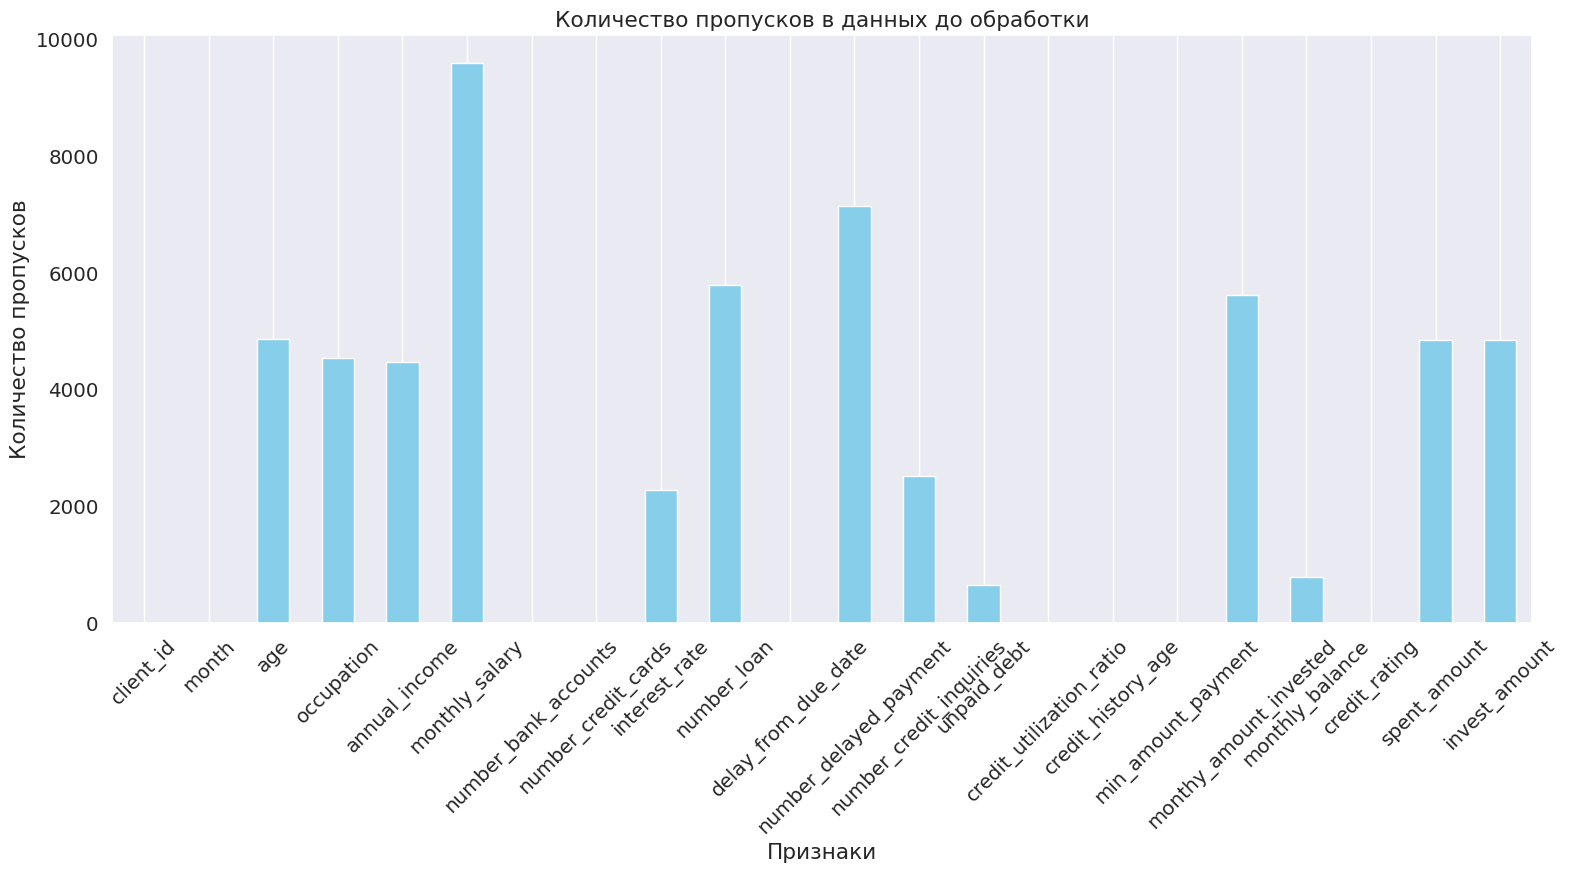

In [259]:
missing_counts = train.isnull().sum()

# Строим гистограмму
plt.figure(figsize=(16, 9))
missing_counts.plot(kind='bar', color='skyblue')
plt.title('Количество пропусков в данных до обработки')
plt.xlabel('Признаки')
plt.ylabel('Количество пропусков')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

По признакам `number_bank_accounts` и `number_credit_cards` и по жизненному опыту видно, что все что до ~10 еще может быть реальным, все что выше-техническая ошибка. Поэтому заменим выбивающиеся значения на самое частое по тому же `client_id` либо поставим 0 если запись для этого id всего одна. То же самое проделаем с вещественными признаками, по которым много выбросов, только вместо самого частого-среднее, а именно: `age`, `interest_rate`, `number_loan`, `delay_from_due_date`, и `monthly_amount_invested`.Так же попытаемся восстановить самым частым значением `min_amount_payment` и `occupation`. После этого, прологарифмируем все вещественные признаки.

In [260]:
def replace_numbers(group):
    replace_ints = ['number_bank_accounts', 'number_credit_cards']
    for cat in replace_ints:
        if len(group) == 1:
            if group[cat].iloc[0] > 10:
                group[cat] = np.nan
        else:
            most_frequent_num = group[cat].mode(dropna=True)[0]
            group[cat] = group[cat].where(group[cat] > 10, most_frequent_num)
    replace_cats = ['occupation', 'min_amount_payment', 'spent_amount', 'invest_amount']
    for cat in replace_cats:
        if len(group) == 1:
            continue
        else:
            most_frequent_cat = group[cat].mode(dropna=True)[0]
            group[cat] = group[cat].where(pd.notna(group[cat]), most_frequent_cat)
    replace_reals = ['age', 'annual_income', 'monthly_salary', 'interest_rate', 'number_loan', 'delay_from_due_date', 'monthy_amount_invested', 'delay_from_due_date']
    for cat in replace_reals:
        if len(group) == 1:
            continue
        else:
            mean = group[cat].median()
            group[cat] = group[cat].where(pd.notna(group[cat]), mean)
    return group


train = train.groupby('client_id').apply(replace_numbers).reset_index(drop=True)
test = test.groupby('client_id').apply(replace_numbers).reset_index(drop=True)

train

/tmp/ipykernel_32868/2544331435.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train = train.groupby('client_id').apply(replace_numbers).reset_index(drop=True)
/tmp/ipykernel_32868/2544331435.py:28: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test = test.groupby('client_id').apply(replace_numbers).reset_index(drop=True)


,client_id,month,age,occupation,annual_income,monthly_salary,number_bank_accounts,number_credit_cards,interest_rate,number_loan,...,number_credit_inquiries,unpaid_debt,credit_utilization_ratio,credit_history_age,min_amount_payment,monthy_amount_invested,monthly_balance,credit_rating,spent_amount,invest_amount
0,0016d1b737,Февраль,36.0,Архитектор,119835.260,10157.60250,1,3,6.0,1.0,...,2.0,489.86,29.480531,197,No,755.132399,476.346124,Хороший,Малые траты,малые платежи
1,0016d1b737,Март,36.0,Архитектор,119862.860,10105.40250,1,3,6.0,1.0,...,2.0,489.86,43.097420,198,No,217.475330,968.413193,Хороший,Большие траты,большие платежи
2,0016d1b737,Апрель,36.0,Архитектор,119143.580,10150.37250,1,3,6.0,1.0,...,2.0,489.86,40.765860,199,No,670.091195,554.297329,Хороший,Малые траты,средние платежи
3,0016d1b737,Май,36.0,Архитектор,119750.790,10124.54250,1,3,6.0,1.0,...,2.0,489.86,29.735696,200,No,1258.433440,NaN,Хороший,Малые траты,малые платежи
4,0016d1b737,Июнь,37.0,Архитектор,119010.970,10132.50250,1,3,6.0,1.0,...,2.0,489.86,44.330831,201,No,234.593027,943.655496,Хороший,Большие траты,большие платежи
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63995,fff686107c,Май,35.0,Учитель,22373.095,2090.53125,5,5,10.0,2.0,...,0.0,1472.78,41.208002,298,No,85.183985,385.944341,Хороший,Малые траты,малые платежи
63996,fff686107c,Июнь,35.0,Учитель,21788.715,2079.73125,5,5,10.0,2.0,...,0.0,1472.78,38.329164,0,No,129.981630,311.046696,Обычный,Большие траты,малые платежи
63997,fff686107c,Июль,35.0,Учитель,21824.405,2084.36125,5,5,10.0,2.0,...,0.0,1472.78,36.168892,300,No,20.928846,398.129480,Хороший,Большие траты,большие платежи
63998,fff686107c,Август,35.0,Учитель,21440.535,2070.54125,5,5,10.0,2.0,...,NaN,1472.78,28.280572,301,No,43.688861,381.179465,Хороший,Большие траты,средние платежи


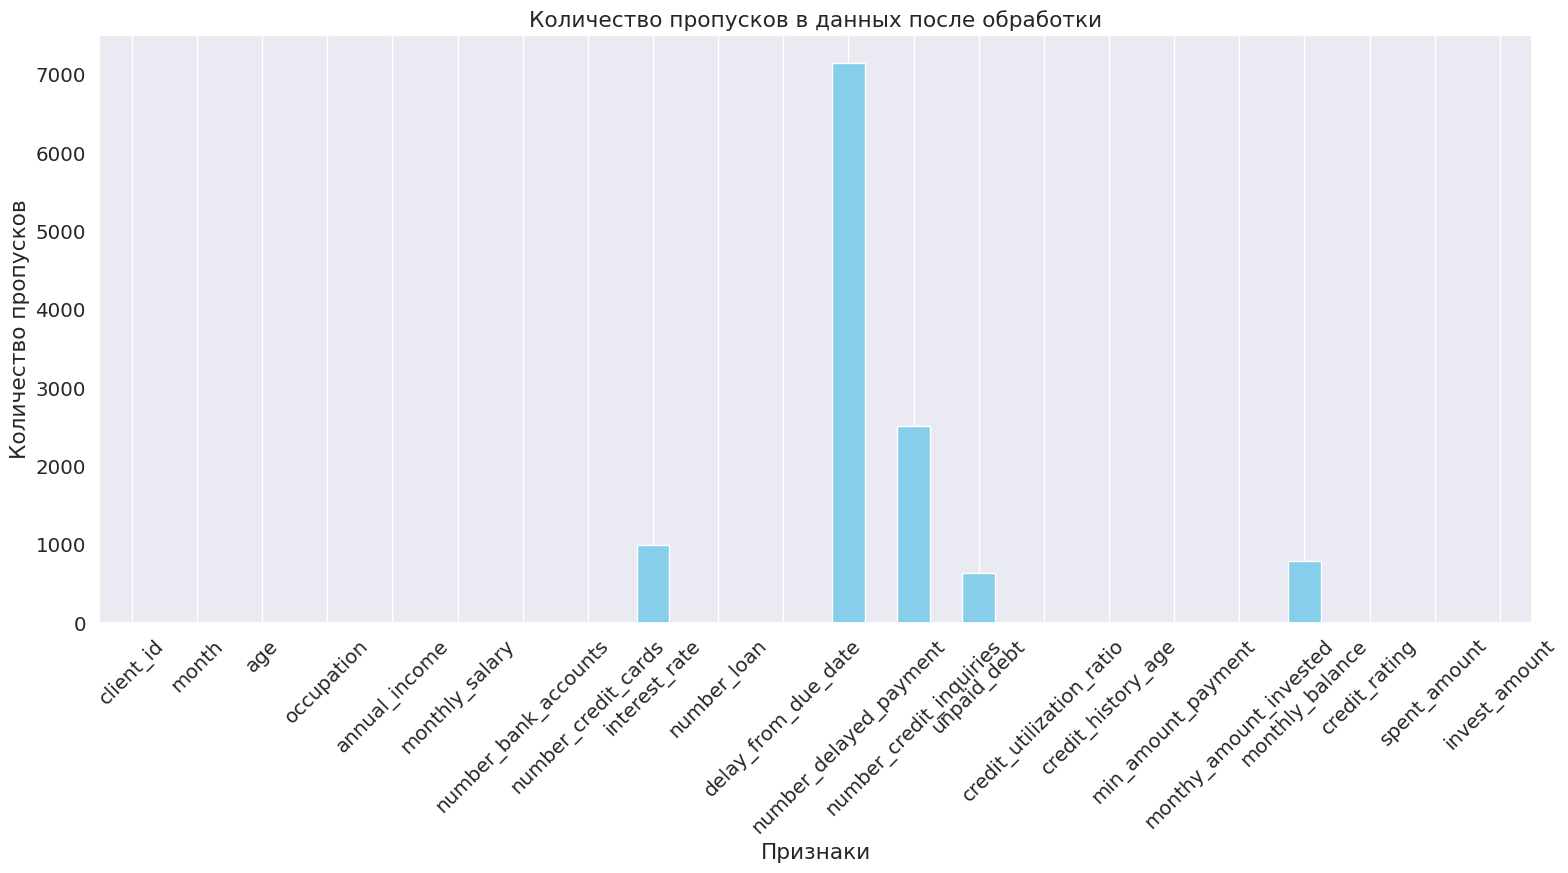

In [261]:
missing_counts = train.isnull().sum()

# Строим гистограмму
plt.figure(figsize=(16, 9))
missing_counts.plot(kind='bar', color='skyblue')
plt.title('Количество пропусков в данных после обработки')
plt.xlabel('Признаки')
plt.ylabel('Количество пропусков')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Удалось устранить пропуски по `spent_amount` и `invest_amount` (бывш. `client_behaviour`), а также по `occupation`, приятно. Приведем все текстовые признаки к lowercase и давайте подбирать параметры:

In [262]:
train[cat_features] = test[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)
for feature in cat_features:
    train[feature] = train[feature].apply(fill_nans_str)
    test[feature] = test[feature].apply(fill_nans_str)
    train[feature] = train[feature].str.lower()
    test[feature] = test[feature].str.lower()

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

def convert_to_months(age_str):
    if pd.isna(age_str):
        return 0
    years, months = 0, 0
    parts = age_str.split()
    for i in range(len(parts)):
        if 'г.' in parts[i]:
            years = int(parts[i-1])
        elif 'м.' in parts[i]:
            months = int(parts[i-1])
    return years * 12 + months

train['credit_history_age'] = train['credit_history_age'].apply(convert_to_months)
test['credit_history_age'] = test['credit_history_age'].apply(convert_to_months)

train[['spent_amount', 'invest_amount']] = train['client_behaviour'].str.split(', ', expand=True)
test[['spent_amount', 'invest_amount']] = test['client_behaviour'].str.split(', ', expand=True)

train.drop(columns=['client_behaviour'], inplace=True)
test.drop(columns=['client_behaviour'], inplace=True)

def fill_nans_str(str):
    if pd.isna(str):
        return "nan"
    else:
        return str
    
target = 'credit_rating'
cat_features = ['occupation', 'month', 'min_amount_payment', 'spent_amount', 'invest_amount']
real_features = ['age', 'annual_income', 'monthly_salary', 'number_bank_accounts', 'credit_history_age','number_credit_cards', 'interest_rate', 'number_loan', 'delay_from_due_date', 'number_delayed_payment', 'number_credit_inquiries', 'unpaid_debt', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_balance']
train[cat_features] = test[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)
for feature in cat_features:
    train[feature] = train[feature].apply(fill_nans_str)
    test[feature] = test[feature].apply(fill_nans_str)
    train[feature] = train[feature].str.lower()
    test[feature] = test[feature].str.lower()

train['sum_delay'] = train['delay_from_due_date'] * train['number_delayed_payment']
test['sum_delay'] = test['delay_from_due_date'] * test['number_delayed_payment']
train = train.drop(columns=['delay_from_due_date', 'number_delayed_payment'])
test = test.drop(columns=['delay_from_due_date', 'number_delayed_payment'])

train['num_rejects'] = train['number_credit_inquiries'] - train['number_loan']
test['num_rejects'] = test['number_credit_inquiries'] - test['number_loan']
train = train.drop(columns=['number_credit_inquiries', 'number_loan'])
test = test.drop(columns=['number_credit_inquiries', 'number_loan'])

bad_features = ['annual_income', 'monthly_balance', 'credit_utilization_ratio']
X_train, X_val, y_train, y_val = train_test_split(
    train.drop(columns=['credit_rating', 'client_id']), 
    train['credit_rating'], test_size=0.05
)
param_distributions = {
    'n_estimators' : np.arange(1, 400),
    'max_depth' : range(5, 10),
    'learning_rate' : np.linspace(0.01, 0.3, 10000),
    'min_data_in_leaf' : np.arange(1, 7),
    'l2_leaf_reg' : np.linspace(0, 10, 101),
    #'rsm' : np.linspace(0.5, 1, 100)
}

sss = StratifiedShuffleSplit(n_splits=3, random_state=1337, test_size=0.25)
# определяем поиск по сетке
second_catboost = RandomizedSearchCV(
    estimator=CatBoostClassifier(cat_features=cat_features,
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features),
    param_distributions=param_distributions,
    scoring='accuracy',
    n_iter=300,
    n_jobs=1,
    cv=sss,
    verbose=10,
    error_score='raise',
    random_state=42
)

second_catboost.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV 1/3; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368
[CV 1/3; 1/300] END l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368;, score=0.696 total time=   3.5s
[CV 2/3; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368
[CV 2/3; 1/300] END l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368;, score=0.696 total time=   2.1s
[CV 3/3; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368
[CV 3/3; 1/300] END l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368;, score=0.694 total time=   2.1s
[CV 1/3; 2/300] START l2_leaf_reg=0.6000000000000001, learning_rate=0.17873887388738874, max_d

/home/roman/HW/myenv2/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=1337, test_size=0.25,
            train_size=None),
                   error_score='raise',
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f4ec1d3c4d0>,
                   n_iter=300, n_jobs=1,
                   param_distributions={'l2_leaf_reg': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2....
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390,
       391, 392, 393, 394, 395, 396, 397, 398, 399])},
                   random_state=42, scoring='accuracy', verbose=10)

In [3]:
second_catboost.best_score_

0.7344298245614036

In [4]:
second_catboost.best_params_

{'n_estimators': 391,
 'min_data_in_leaf': 1,
 'max_depth': 9,
 'learning_rate': 0.26290529052905287,
 'l2_leaf_reg': 1.5}

In [23]:
second_catboost_params = {'n_estimators': 391,
 'min_data_in_leaf': 1,
 'max_depth': 9,
 'learning_rate': 0.26290529052905287,
 'l2_leaf_reg': 1.5}
bad_features = ['annual_income', 'credit_utilization_ratio']
second_catboost_model = CatBoostClassifier(cat_features=cat_features,
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features, **second_catboost_params)
second_catboost_model.fit(X_train, y_train)
accuracy_score(y_val, second_catboost_model.predict(X_val))

0.740625

In [12]:
for value, name in sorted(
    zip(second_catboost_model.get_feature_importance(fstr_type='FeatureImportance'), 
        X_train), 
    reverse=True
):
    print('{}\t{:.2f}'.format(name, value))

unpaid_debt	11.84
interest_rate	10.91
age	9.59
credit_history_age	9.05
sum_delay	8.51
number_credit_cards	8.46
monthly_salary	8.19
number_bank_accounts	7.65
num_rejects	7.21
month	5.56
monthy_amount_invested	5.30
occupation	3.16
min_amount_payment	2.31
spent_amount	1.77
invest_amount	0.51
monthly_balance	0.00
credit_utilization_ratio	0.00
annual_income	0.00


In [24]:
pred = second_catboost_model.predict(test.drop(columns='client_id').values)
train = pd.DataFrame(pred, columns=['credit_rating'])
train.to_csv("predictions_2_1.csv", sep=",", index_label='index')

In [25]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

def convert_to_months(age_str):
    if pd.isna(age_str):
        return 0
    years, months = 0, 0
    parts = age_str.split()
    for i in range(len(parts)):
        if 'г.' in parts[i]:
            years = int(parts[i-1])
        elif 'м.' in parts[i]:
            months = int(parts[i-1])
    return years * 12 + months

train['credit_history_age'] = train['credit_history_age'].apply(convert_to_months)
test['credit_history_age'] = test['credit_history_age'].apply(convert_to_months)

train[['spent_amount', 'invest_amount']] = train['client_behaviour'].str.split(', ', expand=True)
test[['spent_amount', 'invest_amount']] = test['client_behaviour'].str.split(', ', expand=True)

train.drop(columns=['client_behaviour'], inplace=True)
test.drop(columns=['client_behaviour'], inplace=True)

def fill_nans_str(str):
    if pd.isna(str):
        return "nan"
    else:
        return str
    
target = 'credit_rating'
cat_features = ['occupation', 'month', 'min_amount_payment', 'spent_amount', 'invest_amount']
real_features = ['age', 'annual_income', 'monthly_salary', 'number_bank_accounts', 'credit_history_age','number_credit_cards', 'interest_rate', 'number_loan', 'delay_from_due_date', 'number_delayed_payment', 'number_credit_inquiries', 'unpaid_debt', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_balance']
train[cat_features] = test[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)
for feature in cat_features:
    train[feature] = train[feature].apply(fill_nans_str)
    test[feature] = test[feature].apply(fill_nans_str)
    train[feature] = train[feature].str.lower()
    test[feature] = test[feature].str.lower()

train['sum_delay'] = train['delay_from_due_date'] * train['number_delayed_payment']
test['sum_delay'] = test['delay_from_due_date'] * test['number_delayed_payment']
#train = train.drop(columns=['delay_from_due_date', 'number_delayed_payment'])
#test = test.drop(columns=['delay_from_due_date', 'number_delayed_payment'])

train['num_rejects'] = train['number_credit_inquiries'] - train['number_loan']
test['num_rejects'] = test['number_credit_inquiries'] - test['number_loan']
#train = train.drop(columns=['number_credit_inquiries', 'number_loan'])
#test = test.drop(columns=['number_credit_inquiries', 'number_loan'])

bad_features = ['annual_income', 'credit_utilization_ratio']
X_train, X_val, y_train, y_val = train_test_split(
    train.drop(columns=['credit_rating', 'client_id']), 
    train['credit_rating'], test_size=0.05
)
param_distributions = {
    'n_estimators' : np.arange(1, 400),
    'max_depth' : range(5, 10),
    'learning_rate' : np.linspace(0.01, 0.3, 10000),
    'min_data_in_leaf' : np.arange(1, 7),
    'l2_leaf_reg' : np.linspace(0, 10, 101),
    #'rsm' : np.linspace(0.5, 1, 100)
}

sss = StratifiedShuffleSplit(n_splits=3, random_state=1337, test_size=0.25)
# определяем поиск по сетке
second_catboost = RandomizedSearchCV(
    estimator=CatBoostClassifier(cat_features=cat_features,
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features),
    param_distributions=param_distributions,
    scoring='accuracy',
    n_iter=300,
    n_jobs=1,
    cv=sss,
    verbose=10,
    error_score='raise',
    random_state=42
)

second_catboost.fit(X_train, y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV 1/3; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368
[CV 1/3; 1/300] END l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368;, score=0.709 total time=   2.1s
[CV 2/3; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368
[CV 2/3; 1/300] END l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368;, score=0.699 total time=   2.2s
[CV 3/3; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368
[CV 3/3; 1/300] END l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368;, score=0.698 total time=   2.1s
[CV 1/3; 2/300] START l2_leaf_reg=0.6000000000000001, learning_rate=0.17873887388738874, max_d

/home/roman/HW/myenv2/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=StratifiedShuffleSplit(n_splits=3, random_state=1337, test_size=0.25,
            train_size=None),
                   error_score='raise',
                   estimator=<catboost.core.CatBoostClassifier object at 0x7f4ebf699a10>,
                   n_iter=300, n_jobs=1,
                   param_distributions={'l2_leaf_reg': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2....
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390,
       391, 392, 393, 394, 395, 396, 397, 398, 399])},
                   random_state=42, scoring='accuracy', verbose=10)

In [26]:
second_catboost.best_score_

0.748201754385965

In [27]:
second_catboost.best_params_

{'n_estimators': 391,
 'min_data_in_leaf': 1,
 'max_depth': 9,
 'learning_rate': 0.26290529052905287,
 'l2_leaf_reg': 1.5}

In [28]:
second_catboost_params = {'n_estimators': 391,
 'min_data_in_leaf': 1,
 'max_depth': 9,
 'learning_rate': 0.26290529052905287,
 'l2_leaf_reg': 1.5}
bad_features = ['annual_income', 'credit_utilization_ratio']
second_catboost_model = CatBoostClassifier(cat_features=cat_features,
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features, **second_catboost_params)
second_catboost_model.fit(X_train, y_train)
accuracy_score(y_val, second_catboost_model.predict(X_val))

0.7521875

In [29]:
for value, name in sorted(
    zip(second_catboost_model.get_feature_importance(fstr_type='FeatureImportance'), 
        X_train), 
    reverse=True
):
    print('{}\t{:.2f}'.format(name, value))

interest_rate	9.99
unpaid_debt	9.81
age	7.77
credit_history_age	7.42
delay_from_due_date	7.15
number_credit_cards	6.78
number_bank_accounts	6.09
monthly_salary	5.99
number_credit_inquiries	4.68
monthy_amount_invested	4.60
occupation	4.25
monthly_balance	4.19
number_loan	4.18
sum_delay	3.85
number_delayed_payment	3.67
month	3.46
num_rejects	3.30
min_amount_payment	1.15
spent_amount	1.09
invest_amount	0.57
credit_utilization_ratio	0.00
annual_income	0.00


In [30]:
pred = second_catboost_model.predict(test.drop(columns='client_id').values)
train = pd.DataFrame(pred, columns=['credit_rating'])
train.to_csv("predictions_2_2.csv", sep=",", index_label='index')

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

def convert_to_months(age_str):
    if pd.isna(age_str):
        return 0
    years, months = 0, 0
    parts = age_str.split()
    for i in range(len(parts)):
        if 'г.' in parts[i]:
            years = int(parts[i-1])
        elif 'м.' in parts[i]:
            months = int(parts[i-1])
    return years * 12 + months

train['credit_history_age'] = train['credit_history_age'].apply(convert_to_months)
test['credit_history_age'] = test['credit_history_age'].apply(convert_to_months)

train[['spent_amount', 'invest_amount']] = train['client_behaviour'].str.split(', ', expand=True)
test[['spent_amount', 'invest_amount']] = test['client_behaviour'].str.split(', ', expand=True)

train.drop(columns=['client_behaviour'], inplace=True)
test.drop(columns=['client_behaviour'], inplace=True)

def fill_nans_str(str):
    if pd.isna(str):
        return "nan"
    else:
        return str
    
target = 'credit_rating'
cat_features = ['occupation', 'month', 'min_amount_payment', 'spent_amount', 'invest_amount']
real_features = ['age', 'annual_income', 'monthly_salary', 'number_bank_accounts', 'credit_history_age','number_credit_cards', 'interest_rate', 'number_loan', 'delay_from_due_date', 'number_delayed_payment', 'number_credit_inquiries', 'unpaid_debt', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_balance']
train[cat_features] = test[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)
for feature in cat_features:
    train[feature] = train[feature].apply(fill_nans_str)
    test[feature] = test[feature].apply(fill_nans_str)
    train[feature] = train[feature].str.lower()
    test[feature] = test[feature].str.lower()

train['sum_delay'] = train['delay_from_due_date'] * train['number_delayed_payment']
test['sum_delay'] = test['delay_from_due_date'] * test['number_delayed_payment']
#train = train.drop(columns=['delay_from_due_date', 'number_delayed_payment'])
#test = test.drop(columns=['delay_from_due_date', 'number_delayed_payment'])

train['num_rejects'] = train['number_credit_inquiries'] - train['number_loan']
test['num_rejects'] = test['number_credit_inquiries'] - test['number_loan']
#train = train.drop(columns=['number_credit_inquiries', 'number_loan'])
#test = test.drop(columns=['number_credit_inquiries', 'number_loan'])

train['percent_credit'] = train['monthy_amount_invested'] / train['monthly_salary']
test['percent_credit'] = test['monthy_amount_invested'] / test['monthly_salary']

bad_features = ['annual_income', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_salary']
param_distributions = {
    'n_estimators' : np.arange(1, 400),
    'max_depth' : range(5, 10),
    'learning_rate' : np.linspace(0.01, 0.3, 10000),
    'min_data_in_leaf' : np.arange(1, 7),
    'l2_leaf_reg' : np.linspace(0, 10, 101),
    #'rsm' : np.linspace(0.5, 1, 100)
}

sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=1337)
# определяем поиск по сетке
second_catboost = RandomizedSearchCV(
    estimator=CatBoostClassifier(cat_features=cat_features,
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features),
    param_distributions=param_distributions,
    scoring='accuracy',
    n_iter=300,
    n_jobs=1,
    cv=sgkf.split(train.drop(columns=['credit_rating', 'client_id']), train['credit_rating'], train['client_id']),
    verbose=10,
    error_score='raise',
    random_state=42
)

second_catboost.fit(train.drop(columns=['credit_rating', 'client_id']), train['credit_rating'])

Fitting 3 folds for each of 300 candidates, totalling 900 fits
[CV 1/3; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368
[CV 1/3; 1/300] END l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368;, score=0.662 total time=   3.8s
[CV 2/3; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368
[CV 2/3; 1/300] END l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368;, score=0.664 total time=   2.4s
[CV 3/3; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368
[CV 3/3; 1/300] END l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368;, score=0.667 total time=   2.5s
[CV 1/3; 2/300] START l2_leaf_reg=0.6000000000000001, learning_rate=0.17873887388738874, max_d

/home/roman/HW/myenv2/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x787ab2ec0700>,
                   error_score='raise',
                   estimator=<catboost.core.CatBoostClassifier object at 0x787ab10ee8d0>,
                   n_iter=300, n_jobs=1,
                   param_distributions={'l2_leaf_reg': array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3...
       313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325,
       326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338,
       339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351,
       352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364,
       365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377,
       378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390,
       391, 392, 393, 394, 395, 396, 397, 398, 399])},
                   random_state=42, scoring='accuracy', verbose=10)

In [3]:
second_catboost.best_score_

0.6675621790243212

In [6]:
for value, name in sorted(
    zip(second_catboost.best_estimator_.get_feature_importance(fstr_type='FeatureImportance'), 
        train.drop(columns=['credit_rating', 'client_id'])), 
    reverse=True
):
    print('{}\t{:.2f}'.format(name, value))

interest_rate	17.78
unpaid_debt	17.70
number_credit_cards	11.38
delay_from_due_date	10.13
number_bank_accounts	7.27
credit_history_age	6.56
number_credit_inquiries	5.13
age	4.55
number_delayed_payment	3.81
occupation	3.38
sum_delay	2.81
number_loan	2.80
month	2.49
monthly_balance	1.99
num_rejects	1.49
percent_credit	0.62
invest_amount	0.13
min_amount_payment	0.00
spent_amount	0.00
monthy_amount_invested	0.00
monthly_salary	0.00
credit_utilization_ratio	0.00
annual_income	0.00


In [7]:
second_catboost.best_params_

{'n_estimators': 244,
 'min_data_in_leaf': 5,
 'max_depth': 7,
 'learning_rate': 0.06548254825482548,
 'l2_leaf_reg': 5.0}

In [49]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

def convert_to_months(age_str):
    if pd.isna(age_str):
        return 0
    years, months = 0, 0
    parts = age_str.split()
    for i in range(len(parts)):
        if 'г.' in parts[i]:
            years = int(parts[i-1])
        elif 'м.' in parts[i]:
            months = int(parts[i-1])
    return years * 12 + months

def replace_numbers(group):
    replace_cats = ['occupation']
    for cat in replace_cats:
        if len(group) == 1:
            continue
        else:
            most_frequent_cat = group[cat].mode(dropna=True)[0]
            group[cat] = group[cat].where(pd.isna(group[cat]), most_frequent_cat)
    replace_reals = ['age', 'monthly_salary']
    for cat in replace_reals:
        if len(group) == 1:
            continue
        else:
            mean = group[cat].median()
            group[cat] = group[cat].where(pd.isna(group[cat]), mean)
    return group


#train = train.groupby('client_id').apply(replace_numbers).reset_index(drop=True)
#test = test.groupby('client_id').apply(replace_numbers).reset_index(drop=True)

train['credit_history_age'] = train['credit_history_age'].apply(convert_to_months)
test['credit_history_age'] = test['credit_history_age'].apply(convert_to_months)

train[['spent_amount', 'invest_amount']] = train['client_behaviour'].str.split(', ', expand=True)
test[['spent_amount', 'invest_amount']] = test['client_behaviour'].str.split(', ', expand=True)

train.drop(columns=['client_behaviour'], inplace=True)
test.drop(columns=['client_behaviour'], inplace=True)

def fill_nans_str(str):
    if pd.isna(str):
        return "nan"
    else:
        return str
    
target = 'credit_rating'
cat_features = ['occupation', 'month', 'min_amount_payment', 'spent_amount', 'invest_amount']
real_features = ['age', 'annual_income', 'monthly_salary', 'number_bank_accounts', 'credit_history_age','number_credit_cards', 'interest_rate', 'number_loan', 'delay_from_due_date', 'number_delayed_payment', 'number_credit_inquiries', 'unpaid_debt', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_balance']
train[cat_features] = test[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)
for feature in cat_features:
    train[feature] = train[feature].apply(fill_nans_str)
    test[feature] = test[feature].apply(fill_nans_str)
    train[feature] = train[feature].str.lower()
    test[feature] = test[feature].str.lower()

train['sum_delay'] = train['delay_from_due_date'] * train['number_delayed_payment']
test['sum_delay'] = test['delay_from_due_date'] * test['number_delayed_payment']
#train = train.drop(columns=['delay_from_due_date', 'number_delayed_payment'])
#test = test.drop(columns=['delay_from_due_date', 'number_delayed_payment'])

train['num_rejects'] = train['number_credit_inquiries'] - train['number_loan']
test['num_rejects'] = test['number_credit_inquiries'] - test['number_loan']
#train = train.drop(columns=['number_credit_inquiries', 'number_loan'])
#test = test.drop(columns=['number_credit_inquiries', 'number_loan'])

train['percent_credit'] = train['monthy_amount_invested'] / train['monthly_salary']
test['percent_credit'] = test['monthy_amount_invested'] / test['monthly_salary']

In [17]:
splitter = StratifiedGroupKFold(n_splits=5, shuffle=True)
train_idx, val_idx = next(splitter.split(train.drop(columns=['client_id', 'credit_rating']), train['credit_rating'], groups=train['client_id']))

In [50]:
X_train = train.drop(columns=['client_id', 'credit_rating']).iloc[train_idx]
X_val = train.drop(columns=['client_id', 'credit_rating']).iloc[val_idx]
y_train = train['credit_rating'].iloc[train_idx]
y_val = train['credit_rating'].iloc[val_idx]
bad_features = ['annual_income', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_salary', 'spent_amount']
second_catboost_params = {'n_estimators': 244,
 'min_data_in_leaf': 5,
 'max_depth': 7,
 'learning_rate': 0.06548254825482548,
 'l2_leaf_reg': 5.0}
second_catboost_model = CatBoostClassifier(cat_features=cat_features, 
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features, **second_catboost_params)
second_catboost_model.fit(X_train, y_train)

accuracy_score(y_val, second_catboost_model.predict(X_val))


0.6737976264834479

In [51]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

def convert_to_months(age_str):
    if pd.isna(age_str):
        return 0
    years, months = 0, 0
    parts = age_str.split()
    for i in range(len(parts)):
        if 'г.' in parts[i]:
            years = int(parts[i-1])
        elif 'м.' in parts[i]:
            months = int(parts[i-1])
    return years * 12 + months

train['credit_history_age'] = train['credit_history_age'].apply(convert_to_months)
test['credit_history_age'] = test['credit_history_age'].apply(convert_to_months)

train[['spent_amount', 'invest_amount']] = train['client_behaviour'].str.split(', ', expand=True)
test[['spent_amount', 'invest_amount']] = test['client_behaviour'].str.split(', ', expand=True)

train.drop(columns=['client_behaviour'], inplace=True)
test.drop(columns=['client_behaviour'], inplace=True)

def fill_nans_str(str):
    if pd.isna(str):
        return "nan"
    else:
        return str
    
target = 'credit_rating'
cat_features = ['occupation', 'month', 'min_amount_payment', 'spent_amount', 'invest_amount']
real_features = ['age', 'annual_income', 'monthly_salary', 'number_bank_accounts', 'credit_history_age','number_credit_cards', 'interest_rate', 'number_loan', 'delay_from_due_date', 'number_delayed_payment', 'number_credit_inquiries', 'unpaid_debt', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_balance']
train[cat_features] = test[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)
for feature in cat_features:
    train[feature] = train[feature].apply(fill_nans_str)
    test[feature] = test[feature].apply(fill_nans_str)
    train[feature] = train[feature].str.lower()
    test[feature] = test[feature].str.lower()

train['sum_delay'] = train['delay_from_due_date'] * train['number_delayed_payment']
test['sum_delay'] = test['delay_from_due_date'] * test['number_delayed_payment']
#train = train.drop(columns=['delay_from_due_date', 'number_delayed_payment'])
#test = test.drop(columns=['delay_from_due_date', 'number_delayed_payment'])

train['num_rejects'] = train['number_credit_inquiries'] - train['number_loan']
test['num_rejects'] = test['number_credit_inquiries'] - test['number_loan']
#train = train.drop(columns=['number_credit_inquiries', 'number_loan'])
#test = test.drop(columns=['number_credit_inquiries', 'number_loan'])

train['percent_credit'] = train['monthy_amount_invested'] / train['monthly_salary']
test['percent_credit'] = test['monthy_amount_invested'] / test['monthly_salary']

bad_features = ['annual_income', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_salary', 'spent_amount']
param_distributions = {
    'n_estimators' : np.arange(1, 400),
    'max_depth' : range(5, 10),
    'learning_rate' : np.linspace(0.01, 0.3, 10000),
    'min_data_in_leaf' : np.arange(1, 7),
    'l2_leaf_reg' : np.linspace(0, 10, 101),
    #'rsm' : np.linspace(0.5, 1, 100)
}

sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=1337)
# определяем поиск по сетке
third_catboost = RandomizedSearchCV(
    estimator=CatBoostClassifier(cat_features=cat_features,
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features),
    param_distributions=param_distributions,
    scoring='accuracy',
    n_iter=300,
    n_jobs=1,
    cv=sgkf.split(train.drop(columns=['credit_rating', 'client_id']), train['credit_rating'], train['client_id']),
    verbose=10,
    error_score='raise',
    random_state=42
)

third_catboost.fit(train.drop(columns=['credit_rating', 'client_id']), train['credit_rating'])
third_catboost.best_score_

Fitting 4 folds for each of 300 candidates, totalling 1200 fits
[CV 1/4; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368
[CV 1/4; 1/300] END l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368;, score=0.672 total time=   2.1s
[CV 2/4; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368
[CV 2/4; 1/300] END l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368;, score=0.660 total time=   2.1s
[CV 3/4; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368
[CV 3/4; 1/300] END l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368;, score=0.671 total time=   2.1s
[CV 4/4; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_d

/home/roman/HW/myenv2/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


0.668015935410234

In [52]:
third_catboost.best_params_

{'n_estimators': 295,
 'min_data_in_leaf': 1,
 'max_depth': 7,
 'learning_rate': 0.08128912891289128,
 'l2_leaf_reg': 5.5}

Посылка 3_1

In [56]:
bad_features = ['annual_income', 'monthy_amount_invested', 'monthly_salary', 'spent_amount']
third_catboost_params = {'n_estimators': 295,
 'min_data_in_leaf': 1,
 'max_depth': 7,
 'learning_rate': 0.08128912891289128,
 'l2_leaf_reg': 5.5}
third_catboost_model = CatBoostClassifier(cat_features=cat_features, 
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features, **second_catboost_params)
third_catboost_model.fit(train.drop(columns=['credit_rating', 'client_id']), train['credit_rating'])

In [58]:
for value, name in sorted(
    zip(third_catboost_model.get_feature_importance(fstr_type='FeatureImportance'), 
        train.drop(columns=['credit_rating', 'client_id'])), 
    reverse=True
):
    print('{}\t{:.2f}'.format(name, value))

unpaid_debt	17.76
interest_rate	17.70
number_credit_cards	11.25
delay_from_due_date	9.71
number_bank_accounts	7.02
credit_history_age	6.55
number_credit_inquiries	5.32
age	4.82
number_delayed_payment	3.94
occupation	3.40
number_loan	3.13
sum_delay	2.73
month	2.25
monthly_balance	1.89
num_rejects	1.60
percent_credit	0.54
credit_utilization_ratio	0.24
invest_amount	0.15
min_amount_payment	0.00
spent_amount	0.00
monthy_amount_invested	0.00
monthly_salary	0.00
annual_income	0.00


In [57]:
pred = third_catboost_model.predict(test.drop(columns='client_id').values)
train = pd.DataFrame(pred, columns=['credit_rating'])
train.to_csv("predictions_3_2.csv", sep=",", index_label='index')

In [77]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

def convert_to_months(age_str):
    if pd.isna(age_str):
        return 0
    years, months = 0, 0
    parts = age_str.split()
    for i in range(len(parts)):
        if 'г.' in parts[i]:
            years = int(parts[i-1])
        elif 'м.' in parts[i]:
            months = int(parts[i-1])
    return years * 12 + months

def parse_min_payment(str):
    if pd.isna(str):
        return "nan"
    elif (str == 'Yes'):
        return 1
    else:
        return 0

train['min_amount_payment'] = train['min_amount_payment'].apply(parse_min_payment)
test['min_amount_payment'] = test['min_amount_payment'].apply(parse_min_payment)

train_grouped = train.groupby('client_id')
train['ever_been_min_payment'] = train_grouped['min_amount_payment'].cummax()
train['min_payment_part'] = train_grouped['min_amount_payment'].cumsum()
train['min_payment_part'] = train['min_payment_part'] / 8 #читерство, что для каждого id ровно 8 записей

test_grouped = test.groupby('client_id')
test['ever_been_min_payment'] = test_grouped['min_amount_payment'].cummax()
test['min_payment_part'] = test_grouped['min_amount_payment'].cumsum()
test['min_payment_part'] = test['min_payment_part'] / 8

train['credit_history_age'] = train['credit_history_age'].apply(convert_to_months)
test['credit_history_age'] = test['credit_history_age'].apply(convert_to_months)

train[['spent_amount', 'invest_amount']] = train['client_behaviour'].str.split(', ', expand=True)
test[['spent_amount', 'invest_amount']] = test['client_behaviour'].str.split(', ', expand=True)

train.drop(columns=['client_behaviour'], inplace=True)
test.drop(columns=['client_behaviour'], inplace=True)

def fill_nans_str(str):
    if pd.isna(str):
        return "nan"
    else:
        return str
    
target = 'credit_rating'
cat_features = ['occupation', 'month', 'spent_amount', 'invest_amount']
real_features = ['age', 'annual_income', 'monthly_salary', 'number_bank_accounts', 'credit_history_age','number_credit_cards', 'interest_rate', 'number_loan', 'delay_from_due_date', 'number_delayed_payment', 'number_credit_inquiries', 'unpaid_debt', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_balance']
train[cat_features] = test[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)
for feature in cat_features:
    train[feature] = train[feature].apply(fill_nans_str)
    test[feature] = test[feature].apply(fill_nans_str)
    train[feature] = train[feature].str.lower()
    test[feature] = test[feature].str.lower()

train['sum_delay'] = train['delay_from_due_date'] * train['number_delayed_payment']
test['sum_delay'] = test['delay_from_due_date'] * test['number_delayed_payment']
#train = train.drop(columns=['delay_from_due_date', 'number_delayed_payment'])
#test = test.drop(columns=['delay_from_due_date', 'number_delayed_payment'])

train['num_rejects'] = train['number_credit_inquiries'] - train['number_loan']
test['num_rejects'] = test['number_credit_inquiries'] - test['number_loan']
#train = train.drop(columns=['number_credit_inquiries', 'number_loan'])
#test = test.drop(columns=['number_credit_inquiries', 'number_loan'])

train['percent_credit'] = train['monthy_amount_invested'] / train['monthly_salary']
test['percent_credit'] = test['monthy_amount_invested'] / test['monthly_salary']

bad_features = ['annual_income', 'monthy_amount_invested', 'monthly_salary', 'spent_amount']
param_distributions = {
    'n_estimators' : np.arange(1, 400),
    'max_depth' : range(5, 10),
    'learning_rate' : np.linspace(0.01, 0.3, 10000),
    'min_data_in_leaf' : np.arange(1, 7),
    'l2_leaf_reg' : np.linspace(0, 10, 101),
    #'rsm' : np.linspace(0.5, 1, 100)
}

sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=1337)
# определяем поиск по сетке
forth_catboost = RandomizedSearchCV(
    estimator=CatBoostClassifier(cat_features=cat_features,
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features),
    param_distributions=param_distributions,
    scoring='accuracy',
    n_iter=300,
    n_jobs=1,
    cv=sgkf.split(train.drop(columns=['credit_rating', 'client_id']), train['credit_rating'], train['client_id']),
    verbose=10,
    error_score='raise',
    random_state=42
)

forth_catboost.fit(train.drop(columns=['credit_rating', 'client_id']), train['credit_rating'])
forth_catboost.best_score_

Fitting 4 folds for each of 300 candidates, totalling 1200 fits
[CV 1/4; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368
[CV 1/4; 1/300] END l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368;, score=0.671 total time=   2.1s
[CV 2/4; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368
[CV 2/4; 1/300] END l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368;, score=0.659 total time=   2.2s
[CV 3/4; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368
[CV 3/4; 1/300] END l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_data_in_leaf=3, n_estimators=368;, score=0.672 total time=   2.2s
[CV 4/4; 1/300] START l2_leaf_reg=10.0, learning_rate=0.10947994799479947, max_depth=6, min_d

/home/roman/HW/myenv2/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


0.6714063887383159

In [78]:
for value, name in sorted(
    zip(forth_catboost.best_estimator_.get_feature_importance(fstr_type='FeatureImportance'), 
        train.drop(columns=['credit_rating', 'client_id'])), 
    reverse=True
):
    print('{}\t{:.2f}'.format(name, value))

unpaid_debt	17.95
interest_rate	13.57
number_credit_cards	11.83
ever_been_min_payment	11.21
delay_from_due_date	9.97
min_payment_part	6.15
number_bank_accounts	6.03
credit_history_age	5.37
number_credit_inquiries	3.69
age	3.51
number_loan	2.70
number_delayed_payment	2.53
num_rejects	1.54
monthly_balance	1.46
sum_delay	1.28
min_amount_payment	0.73
percent_credit	0.33
credit_utilization_ratio	0.14
spent_amount	0.00
occupation	0.00
monthy_amount_invested	0.00
monthly_salary	0.00
month	0.00
invest_amount	0.00
annual_income	0.00


In [79]:
forth_catboost.best_params_

{'n_estimators': 49,
 'min_data_in_leaf': 2,
 'max_depth': 8,
 'learning_rate': 0.18143614361436142,
 'l2_leaf_reg': 9.8}

**ВОТ ЗДЕСЬ ЛУЧШАЯ МОДЕЛЬ ИЗ ВСЕХ ПОСЫЛОК**

In [84]:
X_train = train.drop(columns=['client_id', 'credit_rating']).iloc[train_idx]
X_val = train.drop(columns=['client_id', 'credit_rating']).iloc[val_idx]
y_train = train['credit_rating'].iloc[train_idx]
y_val = train['credit_rating'].iloc[val_idx]
bad_features = ['annual_income', 'monthy_amount_invested', 'monthly_salary', 'spent_amount']
forth_catboost_params = {'n_estimators': 49,
 'min_data_in_leaf': 2,
 'max_depth': 8,
 'learning_rate': 0.18143614361436142,
 'l2_leaf_reg': 9.8}
forth_catboost_model = CatBoostClassifier(cat_features=cat_features, 
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features, **forth_catboost_params)
forth_catboost_model.fit(train.drop(columns=['credit_rating', 'client_id']), train['credit_rating'])
pred = forth_catboost_model.predict(test.drop(columns='client_id').values)
train = pd.DataFrame(pred, columns=['credit_rating'])
train.to_csv("predictions_4_0.csv", sep=",", index_label='index')

In [23]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

def convert_to_months(age_str):
    if pd.isna(age_str):
        return 0
    years, months = 0, 0
    parts = age_str.split()
    for i in range(len(parts)):
        if 'г.' in parts[i]:
            years = int(parts[i-1])
        elif 'м.' in parts[i]:
            months = int(parts[i-1])
    return years * 12 + months

def parse_min_payment(str):
    if pd.isna(str):
        return "nan"
    elif (str == 'Yes'):
        return 1
    else:
        return 0
    
def code_target(str):
    if(str == 'Хороший'):
        return 3
    elif(str == 'Обычный'):
        return 2
    else:
        return 1

train['min_amount_payment'] = train['min_amount_payment'].apply(parse_min_payment)
test['min_amount_payment'] = test['min_amount_payment'].apply(parse_min_payment)


train_grouped = train.groupby('client_id')
train['ever_been_min_payment'] = train_grouped['min_amount_payment'].cummax()
train['min_payment_part'] = train_grouped['min_amount_payment'].cumsum()
train['min_payment_part'] = train['min_payment_part'] / 8 #читерство, что для каждого id ровно 8 записей

test_grouped = test.groupby('client_id')
test['ever_been_min_payment'] = test_grouped['min_amount_payment'].cummax()
test['min_payment_part'] = test_grouped['min_amount_payment'].cumsum()
test['min_payment_part'] = test['min_payment_part'] / 8

train['credit_history_age'] = train['credit_history_age'].apply(convert_to_months)
test['credit_history_age'] = test['credit_history_age'].apply(convert_to_months)

train[['spent_amount', 'invest_amount']] = train['client_behaviour'].str.split(', ', expand=True)
test[['spent_amount', 'invest_amount']] = test['client_behaviour'].str.split(', ', expand=True)

train.drop(columns=['client_behaviour'], inplace=True)
test.drop(columns=['client_behaviour'], inplace=True)

train_target = train['credit_rating']

train['credit_rating'] = train['credit_rating'].apply(code_target)
def fill_nans_str(str):
    if pd.isna(str):
        return "nan"
    else:
        return str
    
target = 'credit_rating'
cat_features = ['occupation', 'month', 'spent_amount', 'invest_amount']
real_features = ['age', 'annual_income', 'monthly_salary', 'number_bank_accounts', 'credit_history_age','number_credit_cards', 'interest_rate', 'number_loan', 'delay_from_due_date', 'number_delayed_payment', 'number_credit_inquiries', 'unpaid_debt', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_balance']
train[cat_features] = test[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)
for feature in cat_features:
    train[feature] = train[feature].apply(fill_nans_str)
    test[feature] = test[feature].apply(fill_nans_str)
    train[feature] = train[feature].str.lower()
    test[feature] = test[feature].str.lower()

train['sum_delay'] = train['delay_from_due_date'] * train['number_delayed_payment']
test['sum_delay'] = test['delay_from_due_date'] * test['number_delayed_payment']
#train = train.drop(columns=['delay_from_due_date', 'number_delayed_payment'])
#test = test.drop(columns=['delay_from_due_date', 'number_delayed_payment'])

#train['num_rejects'] = train['number_credit_inquiries'] - train['number_loan']
#test['num_rejects'] = test['number_credit_inquiries'] - test['number_loan']
#train = train.drop(columns=['number_credit_inquiries', 'number_loan'])
#test = test.drop(columns=['number_credit_inquiries', 'number_loan'])random.uniform

train['percent_credit'] = train['monthy_amount_invested'] / train['monthly_salary']
test['percent_credit'] = test['monthy_amount_invested'] / test['monthly_salary']

bad_features = ['annual_income', 'monthy_amount_invested', 'monthly_salary', 'spent_amount', 'occupation', 'month']
param_distributions = {
    'n_estimators' : np.arange(1, 300),
    'max_depth' : range(4, 10),
    'learning_rate' : np.linspace(0.01, 0.3, 10000),
    'min_data_in_leaf' : np.arange(1, 7),
    #'max_leaves' : np.arange(1, 64),
    'l2_leaf_reg' : np.linspace(0, 10, 101),
    #'rsm' : np.linspace(0.5, 1, 100)
    #'score_function' : ['Cosine', 'L2Newton,' 'Cosine', 'NewtonL2'],
    'nan_mode' : ['Min', 'Max']
}

sgkf = StratifiedGroupKFold(n_splits=4, shuffle=True, random_state=1337)
# определяем поиск по сетке
forth_catboost = RandomizedSearchCV(
    estimator=CatBoostRegressor(cat_features=cat_features,
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features),
    param_distributions=param_distributions,
    scoring='neg_mean_squared_error',
    n_iter=100,
    n_jobs=1,
    cv=sgkf.split(train.drop(columns=['credit_rating', 'client_id']), train['credit_rating'], train['client_id']),
    verbose=10,
    error_score='raise',
    random_state=42
)

forth_catboost.fit(train.drop(columns=['credit_rating', 'client_id']), train['credit_rating'])
forth_catboost.best_score_

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[CV 1/4; 1/100] START l2_leaf_reg=8.3, learning_rate=0.143993399339934, max_depth=8, min_data_in_leaf=4, n_estimators=47, nan_mode=Min
[CV 1/4; 1/100] END l2_leaf_reg=8.3, learning_rate=0.143993399339934, max_depth=8, min_data_in_leaf=4, n_estimators=47, nan_mode=Min;, score=-0.279 total time=   0.4s
[CV 2/4; 1/100] START l2_leaf_reg=8.3, learning_rate=0.143993399339934, max_depth=8, min_data_in_leaf=4, n_estimators=47, nan_mode=Min
[CV 2/4; 1/100] END l2_leaf_reg=8.3, learning_rate=0.143993399339934, max_depth=8, min_data_in_leaf=4, n_estimators=47, nan_mode=Min;, score=-0.286 total time=   0.5s
[CV 3/4; 1/100] START l2_leaf_reg=8.3, learning_rate=0.143993399339934, max_depth=8, min_data_in_leaf=4, n_estimators=47, nan_mode=Min
[CV 3/4; 1/100] END l2_leaf_reg=8.3, learning_rate=0.143993399339934, max_depth=8, min_data_in_leaf=4, n_estimators=47, nan_mode=Min;, score=-0.275 total time=   0.5s
[CV 4/4; 1/100] START l2_leaf_r

-0.2780429721827174

In [24]:
forth_catboost.best_params_

{'nan_mode': 'Max',
 'n_estimators': 294,
 'min_data_in_leaf': 6,
 'max_depth': 8,
 'learning_rate': 0.025835583558355836,
 'l2_leaf_reg': 7.2}

In [46]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

def convert_to_months(age_str):
    if pd.isna(age_str):
        return 0
    years, months = 0, 0
    parts = age_str.split()
    for i in range(len(parts)):
        if 'г.' in parts[i]:
            years = int(parts[i-1])
        elif 'м.' in parts[i]:
            months = int(parts[i-1])
    return years * 12 + months

def parse_min_payment(str):
    if pd.isna(str):
        return "nan"
    elif (str == 'Yes'):
        return 1
    else:
        return 0
    
def code_target(str):
    if(str == 'Хороший'):
        return 3
    elif(str == 'Обычный'):
        return 2
    else:
        return 1

train['min_amount_payment'] = train['min_amount_payment'].apply(parse_min_payment)
test['min_amount_payment'] = test['min_amount_payment'].apply(parse_min_payment)


train_grouped = train.groupby('client_id')
train['ever_been_min_payment'] = train_grouped['min_amount_payment'].cummax()
train['min_payment_part'] = train_grouped['min_amount_payment'].cumsum()
train['min_payment_part'] = train['min_payment_part'] / 8 #читерство, что для каждого id ровно 8 записей

test_grouped = test.groupby('client_id')
test['ever_been_min_payment'] = test_grouped['min_amount_payment'].cummax()
test['min_payment_part'] = test_grouped['min_amount_payment'].cumsum()
test['min_payment_part'] = test['min_payment_part'] / 8

train['credit_history_age'] = train['credit_history_age'].apply(convert_to_months)
test['credit_history_age'] = test['credit_history_age'].apply(convert_to_months)

train[['spent_amount', 'invest_amount']] = train['client_behaviour'].str.split(', ', expand=True)
test[['spent_amount', 'invest_amount']] = test['client_behaviour'].str.split(', ', expand=True)

train.drop(columns=['client_behaviour'], inplace=True)
test.drop(columns=['client_behaviour'], inplace=True)

train_target = train['credit_rating']

train['credit_rating'] = train['credit_rating'].apply(code_target)
def fill_nans_str(str):
    if pd.isna(str):
        return "nan"
    else:
        return str
    
target = 'credit_rating'
cat_features = ['occupation', 'month', 'spent_amount', 'invest_amount']
real_features = ['age', 'annual_income', 'monthly_salary', 'number_bank_accounts', 'credit_history_age','number_credit_cards', 'interest_rate', 'number_loan', 'delay_from_due_date', 'number_delayed_payment', 'number_credit_inquiries', 'unpaid_debt', 'credit_utilization_ratio', 'monthy_amount_invested', 'monthly_balance']
train[cat_features] = test[cat_features].astype(str)
test[cat_features] = test[cat_features].astype(str)
for feature in cat_features:
    train[feature] = train[feature].apply(fill_nans_str)
    test[feature] = test[feature].apply(fill_nans_str)
    train[feature] = train[feature].str.lower()
    test[feature] = test[feature].str.lower()

train['sum_delay'] = train['delay_from_due_date'] * train['number_delayed_payment']
test['sum_delay'] = test['delay_from_due_date'] * test['number_delayed_payment']
#train = train.drop(columns=['delay_from_due_date', 'number_delayed_payment'])
#test = test.drop(columns=['delay_from_due_date', 'number_delayed_payment'])

#train['num_rejects'] = train['number_credit_inquiries'] - train['number_loan']
#test['num_rejects'] = test['number_credit_inquiries'] - test['number_loan']
#train = train.drop(columns=['number_credit_inquiries', 'number_loan'])
#test = test.drop(columns=['number_credit_inquiries', 'number_loan'])

train['percent_credit'] = train['monthy_amount_invested'] / train['monthly_salary']
test['percent_credit'] = test['monthy_amount_invested'] / test['monthly_salary']

In [47]:
def decode_target(num, a, b):
    if(num < a):
        return "Плохой"
    elif(num < b):
        return "Обычный"
    else:
        return "Хороший"

forth_catboost_params = {'nan_mode': 'Max',
 'n_estimators': 294,
 'min_data_in_leaf': 6,
 'max_depth': 8,
 'learning_rate': 0.025835583558355836,
 'l2_leaf_reg': 7.2}
bad_features = ['annual_income', 'monthy_amount_invested', 'monthly_salary', 'spent_amount', 'occupation', 'month']
forth_catboost_model = CatBoostClassifier(cat_features=cat_features, 
                                 silent=True, task_type='GPU', thread_count=-1, ignored_features=bad_features, **forth_catboost_params)
forth_catboost_model.fit(train.drop(columns=['credit_rating', 'client_id']), train['credit_rating'])
train_pred = forth_catboost_model.predict(train.drop(columns=['credit_rating', 'client_id']))
train_pred = pd.DataFrame(train_pred, columns=['credit_rating'])

In [48]:
train_pred = pd.DataFrame(train_pred, columns=['credit_rating'])

In [54]:

def find_borders(train_target):
    a = np.random.uniform(1, 2, 15)
    b = np.random.uniform(2, 3, 15)
    results = []
    for x in a:
        for y in b:
            train_pred_copy = []
            for i in range(64000):
                train_pred_copy.append(decode_target(a=x, b=y, num=train_pred['credit_rating'].iloc[i]))
            accuracy = accuracy_score(train_target, train_pred_copy), x, y
            results.append([accuracy, x, y])
    return results

results = find_borders(train_target)
print(results)

[[(0.714546875, 1.028079940049551, 2.129069041759652), 1.028079940049551, 2.129069041759652], [(0.714546875, 1.028079940049551, 2.505135788954484), 1.028079940049551, 2.505135788954484], [(0.714546875, 1.028079940049551, 2.0852886192273927), 1.028079940049551, 2.0852886192273927], [(0.714546875, 1.028079940049551, 2.257424684171255), 1.028079940049551, 2.257424684171255], [(0.714546875, 1.028079940049551, 2.4716958290099185), 1.028079940049551, 2.4716958290099185], [(0.714546875, 1.028079940049551, 2.209641303049793), 1.028079940049551, 2.209641303049793], [(0.714546875, 1.028079940049551, 2.980019651482258), 1.028079940049551, 2.980019651482258], [(0.714546875, 1.028079940049551, 2.9373977026244287), 1.028079940049551, 2.9373977026244287], [(0.714546875, 1.028079940049551, 2.8295163609008336), 1.028079940049551, 2.8295163609008336], [(0.714546875, 1.028079940049551, 2.890152896388367), 1.028079940049551, 2.890152896388367], [(0.714546875, 1.028079940049551, 2.007635019767797), 1.02807

In [55]:
max = 0
x_opt = 0
y_opt = 0
for result in results:
    if result[0][0] > max:
        max = result[0][0]
        x_opt = result[0][1]
        y_opt = result[0][2]
print(f"{x_opt}, {y_opt}, {max}")

1.028079940049551, 2.129069041759652, 0.714546875


In [53]:
pred = forth_catboost_model.predict(test.drop(columns='client_id').values)
pred = pd.DataFrame(pred, columns=['credit_rating'])
for i in range(36000):
    pred['credit_rating'].iloc[i] = decode_target(a=x_opt, b=y_opt, num=pred['credit_rating'].iloc[i])
pred.to_csv("predictions_4_3.csv", sep=",", index_label='index')

/tmp/ipykernel_3172/2615300403.py:4: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pred['credit_rating'].iloc[i] = decode_target(a=x_opt, b=y_opt, num=pred['credit_rating'].iloc[i])
/tmp/ipykernel_3172/2615300403.py:4: FutureWarning: Setting

In [20]:
for value, name in sorted(
    zip(forth_catboost_model.get_feature_importance(fstr_type='FeatureImportance'), 
        train.drop(columns=['credit_rating', 'client_id'])), 
    reverse=True
):
    print('{}\t{:.2f}'.format(name, value))

unpaid_debt	17.22
interest_rate	14.31
number_credit_cards	11.73
delay_from_due_date	9.90
min_payment_part	7.82
ever_been_min_payment	7.36
number_bank_accounts	5.58
credit_history_age	5.21
number_credit_inquiries	4.54
number_delayed_payment	3.54
age	3.26
number_loan	2.22
monthly_balance	1.79
num_rejects	1.54
sum_delay	1.51
min_amount_payment	1.32
percent_credit	0.80
credit_utilization_ratio	0.35
spent_amount	0.00
occupation	0.00
monthy_amount_invested	0.00
monthly_salary	0.00
month	0.00
invest_amount	0.00
annual_income	0.00
